# Starbucks Customer Segmentation 
- Bu proje Starbucks şirketine ait verileri içermektedir. Şirket mobil uygulama üzerinden kullanıcılarına teklifler (indirim, reklam, bir alana bir bedava) gönderir. Her teklifin geçerlilik süresi vardır.
- 3 ayrı dosyada veriler tutulmaktadır:
1. portfolio -->  teklif kimliklerini ve her teklifle ilgili meta verileri (süre, tür vb.) içerir
2. profile --> her müşteri için demografik veriler
3. transcript --> işlemler, alınan teklifler, görüntülenen teklifler ve tamamlanan teklifler için kayıtlar
 
- 1. Portfolio Veri Seti:
    - id (string) --> teklif kimliği
    - offer_type (string) --> teklif türü (BOGO, indirim, reklam)
    - difficulty (int) --> bir teklifi tamamlamak için gereken minimum harcama
    - reward (int) --> bir teklifi tamamlamak için verilen ödül
    - duration (int) --> teklifin açık kalacağı süre, gün cinsinden
    - channels --> dize şeklinde listeler (email, web, social...)

- 2. Profile Veri Seti:
    - age (int) --> müşterinin yaşı
    - became_member_on (int) --> müşterinin bir uygulama hesabı oluşturduğu tarih
    - gender (str) --> müşterinin cinsiyeti (m,f,o)
    - id (str) --> müşteri kimliği
    - income (float) --> müşteri geliri

- 3. Transcript Veri Seti:
    - event(str) --> kayıt açıklaması (işlem, alınan teklif, görüntülenen teklif, vb.)
    - id (str) --> müşteri kimliği
    - time (int) --> testin başlangıcından itibaren saat cinsinden zaman.
    - value (dict of strings) --> kayda bağlı olarak bir teklif kimliği veya işlem tutarı


## 1.İlgili Kütüphaneler ve Veri Setlerini Okuma

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt 
import plotly.express as px
import missingno as msno
import math
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer, MinMaxScaler

import plotly.express as px
%matplotlib inline


from datetime import datetime
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer
from sklearn.cluster import KMeans

In [2]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 500)
pd.set_option("display.expand_frame_repr", False)
pd.set_option("display.float_format", lambda x: "%.3f" %x)

In [3]:
#veri setlerini okuma
portfolio = pd.read_csv("C:/Users/esman/OneDrive/Masaüstü/starbucks/portfolio.csv")

profile = pd.read_csv("C:/Users/esman/OneDrive/Masaüstü/starbucks/profile.csv")

transcript = pd.read_csv("C:/Users/esman/OneDrive/Masaüstü/starbucks/transcript.csv")

## 2.EDA(Exploratory Data Analysis) & Data Preparation

In [4]:
#veriye genel bakış
def check_df(dataframe, head=5):
    print("############# SHAPE #############")
    print(dataframe.shape)
    print("############# TYPES #############")
    print(dataframe.dtypes)
    print("############# HEAD #############")
    print(dataframe.head(5))
    print("############# TAİL #############")
    print(dataframe.tail(5))
    print("############# NA #############")
    print(dataframe.isnull().sum())
    print("############# QUANTİLES #############")
    print(dataframe.describe([0, 0.05, 0.5, 0.095, 0.99, 1]).T)

In [5]:
#Değişkenleri Yakalama
def grab_col_names(dataframe, cat_th=5, car_th=10):
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]              

    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and    
                   dataframe[col].dtypes != "O"]

    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]

    cat_cols = cat_cols + num_but_cat

    cat_cols = [col for col in cat_cols if col not in cat_but_car]


    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car

In [6]:
#numerik değişken analizi
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    colors = ['#ff0000', '#00ff00', '#0000ff', '#ffff00', '#ff00ff', '#00ffff',
              '#ff8000', '#8000ff', '#0080ff', '#ff0080', '#80ff00', '#00ff80']
    np.random.shuffle(colors)
    print(dataframe[numerical_col].describe(quantiles).T)
    
    if plot:
        fig, ax = plt.subplots()
        ax.hist(dataframe[numerical_col], bins=20, color=colors[np.random.randint(0, len(colors))])
        ax.set_xlabel(numerical_col)
        ax.set_title(numerical_col)
        plt.show(block=True)

In [7]:
#kategorik değişken analizi
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show(block=True)

In [8]:
#Aykırı Gözlem Analizi
def outlier_analysis(df):
    for column in df.columns:
        if df[column].dtype in [int, float]: 
            sns.boxplot(x=df[column])
            plt.title(f"Aykırı Gözlem Analizi: {column}")
            plt.show()

In [9]:
def outlier_thresholds(dataframe,col_name, q1=0.25, q3=0.75):
  quartile1 = dataframe[col_name].quantile( q1 )
  quartile3 = dataframe[col_name].quantile( q3 )
  interquantile_range = quartile3 - quartile1
  up_limit = quartile3 + 1.5 * interquantile_range
  low_limit = quartile1 - 1.5 * interquantile_range
  return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True  
    else:
        return False 

In [10]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


In [11]:
#Eksik değer tablosu
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    #eksik değer sayısı için;
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    #eksik değer oranı için;
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    #axis=1 ,sütunlara göre birleştirme işlemi yapmak istiyorum.
    #np.round(..) virgülden sonraki basamakla ilgili bir ayarlama yapılmış.
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")

    if na_name:
        return na_columns

In [12]:
# Sayısal değişkenkerin birbirleri ile korelasyonu
def correlation_matrix(df, cols):
    fig = plt.gcf()
    fig.set_size_inches(10, 8)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    fig = sns.heatmap(df[cols].corr(), annot=True, linewidths=0.5, annot_kws={'size': 12}, linecolor='w', cmap='RdBu')
    plt.show(block=True)

### 2.1. EDA for Portfolio

In [13]:
check_df(portfolio)

############# SHAPE #############
(10, 7)
############# TYPES #############
Unnamed: 0     int64
reward         int64
channels      object
difficulty     int64
duration       int64
offer_type    object
id            object
dtype: object
############# HEAD #############
   Unnamed: 0  reward                              channels  difficulty  duration     offer_type                                id
0           0      10         ['email', 'mobile', 'social']          10         7           bogo  ae264e3637204a6fb9bb56bc8210ddfd
1           1      10  ['web', 'email', 'mobile', 'social']          10         5           bogo  4d5c57ea9a6940dd891ad53e9dbe8da0
2           2       0            ['web', 'email', 'mobile']           0         4  informational  3f207df678b143eea3cee63160fa8bed
3           3       5            ['web', 'email', 'mobile']           5         7           bogo  9b98b8c7a33c4b65b9aebfe6a799e6d9
4           4       5                      ['web', 'email']          20    

In [14]:
portfolio = portfolio.drop(columns=["Unnamed: 0"])

In [15]:
portfolio.head(5)

reward                              channels  difficulty  duration     offer_type                                id
0      10         ['email', 'mobile', 'social']          10         7           bogo  ae264e3637204a6fb9bb56bc8210ddfd
1      10  ['web', 'email', 'mobile', 'social']          10         5           bogo  4d5c57ea9a6940dd891ad53e9dbe8da0
2       0            ['web', 'email', 'mobile']           0         4  informational  3f207df678b143eea3cee63160fa8bed
3       5            ['web', 'email', 'mobile']           5         7           bogo  9b98b8c7a33c4b65b9aebfe6a799e6d9
4       5                      ['web', 'email']          20        10       discount  0b1e1539f2cc45b7b9fa7c272da2e1d7

In [16]:
cat_cols, num_cols, cat_but_car = grab_col_names(portfolio)

Observations: 10
Variables: 6
cat_cols: 3
num_cols: 3
cat_but_car: 0
num_but_cat: 0


count   10.000
mean     4.200
std      3.584
min      0.000
5%       0.000
10%      0.000
20%      1.600
30%      2.000
40%      2.600
50%      4.000
60%      5.000
70%      5.000
80%      6.000
90%     10.000
95%     10.000
99%     10.000
max     10.000
Name: reward, dtype: float64


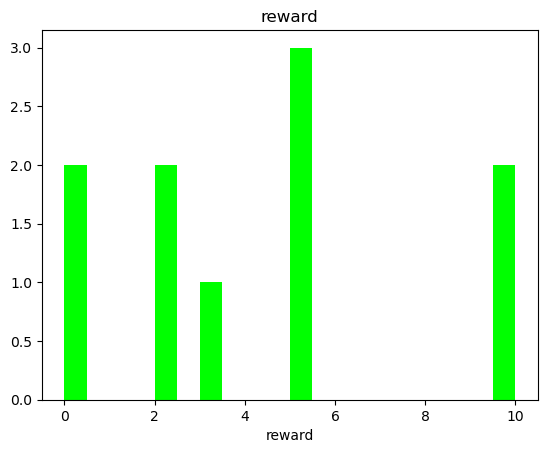

count   10.000
mean     7.700
std      5.832
min      0.000
5%       0.000
10%      0.000
20%      4.000
30%      5.000
40%      6.200
50%      8.500
60%     10.000
70%     10.000
80%     10.000
90%     11.000
95%     15.500
99%     19.100
max     20.000
Name: difficulty, dtype: float64


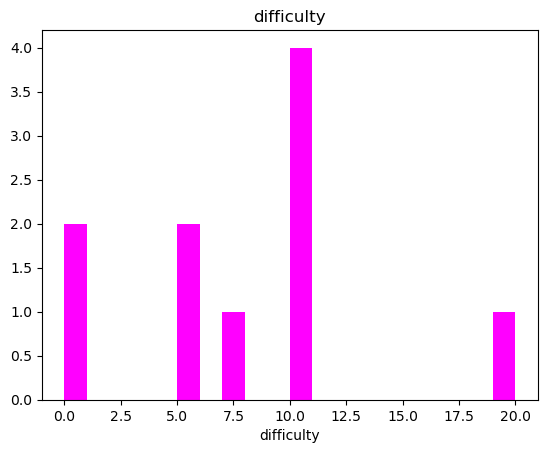

count   10.000
mean     6.500
std      2.321
min      3.000
5%       3.450
10%      3.900
20%      4.800
30%      5.000
40%      6.200
50%      7.000
60%      7.000
70%      7.000
80%      7.600
90%     10.000
95%     10.000
99%     10.000
max     10.000
Name: duration, dtype: float64


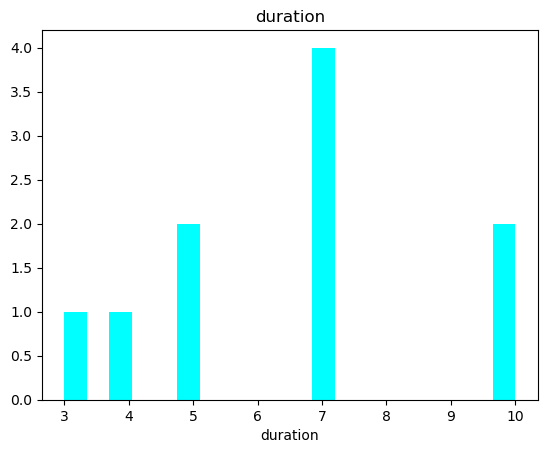

In [17]:
for col in num_cols:
    num_summary(portfolio, col, plot=True)

                                      channels  Ratio
['web', 'email', 'mobile', 'social']         4 40.000
['web', 'email', 'mobile']                   3 30.000
['email', 'mobile', 'social']                2 20.000
['web', 'email']                             1 10.000
##########################################


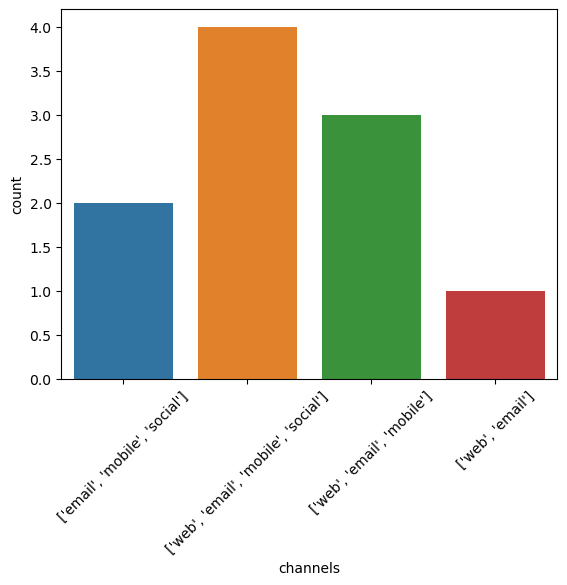

               offer_type  Ratio
bogo                    4 40.000
discount                4 40.000
informational           2 20.000
##########################################


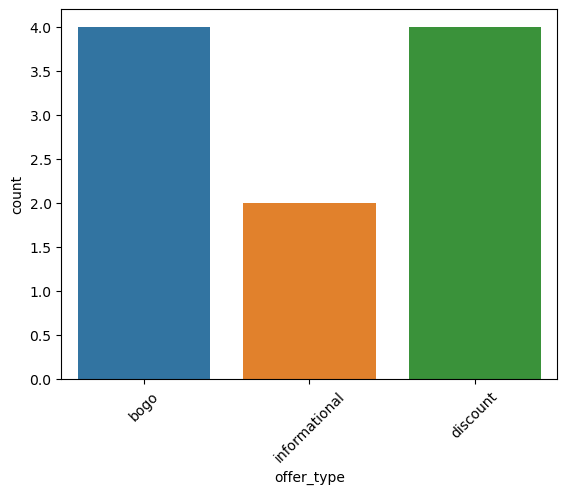

                                  id  Ratio
ae264e3637204a6fb9bb56bc8210ddfd   1 10.000
4d5c57ea9a6940dd891ad53e9dbe8da0   1 10.000
3f207df678b143eea3cee63160fa8bed   1 10.000
9b98b8c7a33c4b65b9aebfe6a799e6d9   1 10.000
0b1e1539f2cc45b7b9fa7c272da2e1d7   1 10.000
2298d6c36e964ae4a3e7e9706d1fb8c2   1 10.000
fafdcd668e3743c1bb461111dcafc2a4   1 10.000
5a8bc65990b245e5a138643cd4eb9837   1 10.000
f19421c1d4aa40978ebb69ca19b0e20d   1 10.000
2906b810c7d4411798c6938adc9daaa5   1 10.000
##########################################


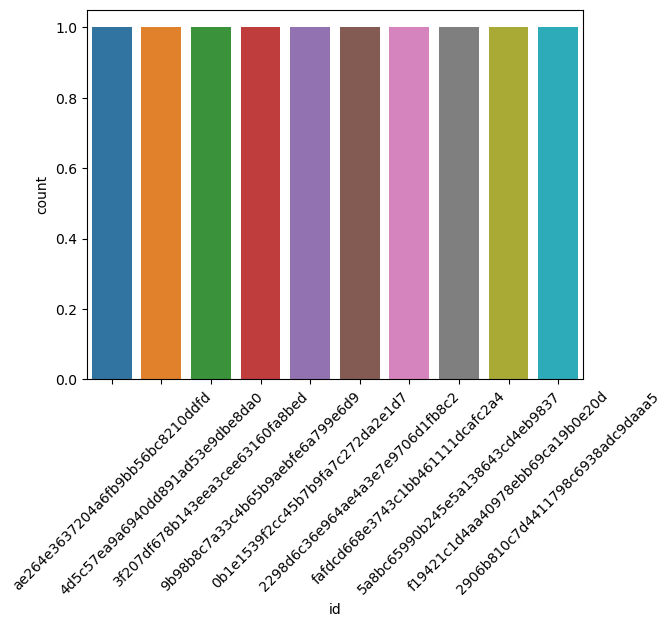

In [18]:
for col in cat_cols:
    plt.xticks(rotation=45)
    cat_summary(portfolio, col, plot=True)

In [19]:
outlier_analysis(portfolio)

In [20]:
for col in num_cols:
    print(col, check_outlier(portfolio, col))

reward True
difficulty True
duration False


In [21]:
for col in num_cols:
    replace_with_thresholds(portfolio, col)

In [22]:
for col in num_cols:
    print(col, check_outlier(portfolio, col))

reward False
difficulty False
duration False


In [23]:
# Missing Values (Eksik Değerler)
portfolio.isnull().values.any()

False

In [24]:
missing_values_table(portfolio) #eksik değer yok

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


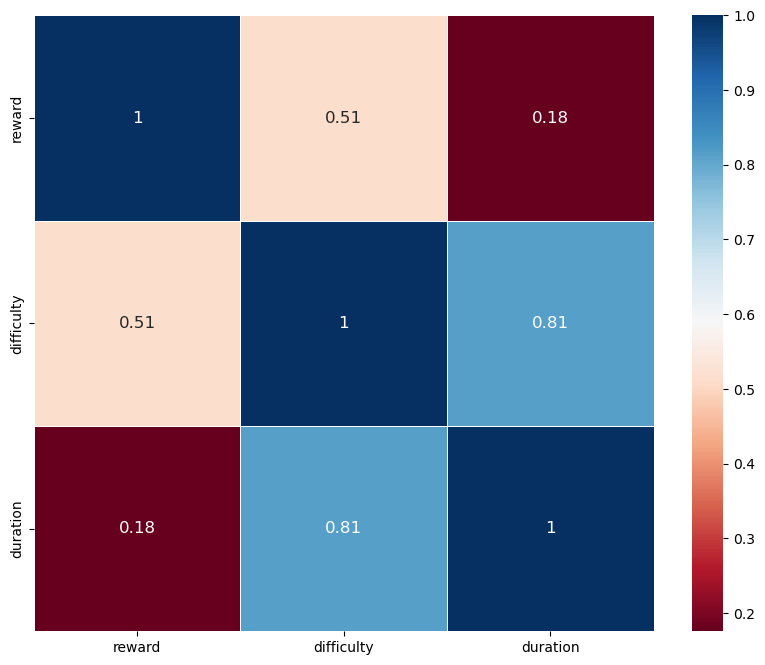

In [25]:
correlation_matrix(portfolio, num_cols)

In [26]:
new_col_names_portfolio = {'difficulty':'offer_difficulty' , 'id':'offer_id', 
                            'duration':'offer_duration', 'reward': 'offer_reward'}
portfolio  = portfolio.rename(columns= new_col_names_portfolio )

In [27]:
portfolio.head(3)

offer_reward                              channels  offer_difficulty  offer_duration     offer_type                          offer_id
0         9.500         ['email', 'mobile', 'social']            10.000               7           bogo  ae264e3637204a6fb9bb56bc8210ddfd
1         9.500  ['web', 'email', 'mobile', 'social']            10.000               5           bogo  4d5c57ea9a6940dd891ad53e9dbe8da0
2         0.000            ['web', 'email', 'mobile']             0.000               4  informational  3f207df678b143eea3cee63160fa8bed

In [28]:
# Medya türlerini ayırmak için fonksiyon tanımlama
def separate_channels(row):
    channels_list = row['channels']
    web = 1 if 'web' in channels_list else 0
    email = 1 if 'email' in channels_list else 0
    mobile = 1 if 'mobile' in channels_list else 0
    social = 1 if 'social' in channels_list else 0
    return pd.Series({'web': web, 'email': email, 'mobile': mobile, 'social': social})

# Medya türlerini ayırarak yeni sütunları oluşturma
new_channels = portfolio.apply(separate_channels, axis=1)

# Oluşturulan yeni sütunları veri çerçevesine ekleme
portfolio = pd.concat([portfolio, new_channels], axis=1)

# 'channels' çıkar
portfolio = portfolio.drop(columns=['channels'])


In [29]:
portfolio  = portfolio[['offer_id','offer_type','offer_difficulty','offer_duration',
                        'web', 'email', 'mobile', 'social']]
portfolio.head(3)

offer_id     offer_type  offer_difficulty  offer_duration  web  email  mobile  social
0  ae264e3637204a6fb9bb56bc8210ddfd           bogo            10.000               7    0      1       1       1
1  4d5c57ea9a6940dd891ad53e9dbe8da0           bogo            10.000               5    1      1       1       1
2  3f207df678b143eea3cee63160fa8bed  informational             0.000               4    1      1       1       0

### 2.2. EDA for Profile

In [30]:
check_df(profile) #eksik değerlerin olduğu görülür

############# SHAPE #############
(17000, 6)
############# TYPES #############
Unnamed: 0            int64
gender               object
age                   int64
id                   object
became_member_on      int64
income              float64
dtype: object
############# HEAD #############
   Unnamed: 0 gender  age                                id  became_member_on     income
0           0    NaN  118  68be06ca386d4c31939f3a4f0e3dd783          20170212        NaN
1           1      F   55  0610b486422d4921ae7d2bf64640c50b          20170715 112000.000
2           2    NaN  118  38fe809add3b4fcf9315a9694bb96ff5          20180712        NaN
3           3      F   75  78afa995795e4d85b5d9ceeca43f5fef          20170509 100000.000
4           4    NaN  118  a03223e636434f42ac4c3df47e8bac43          20170804        NaN
############# TAİL #############
       Unnamed: 0 gender  age                                id  became_member_on    income
16995       16995      F   45  6d5f3a774f3d4714

In [31]:
profile.drop("Unnamed: 0", axis=1, inplace=True)

In [32]:
new_col_profile = {'id':'customer_id' , 'income':'customer_income'}
profile  = profile.rename(columns= new_col_profile )

In [33]:
profile.head(5)

gender  age                       customer_id  became_member_on  customer_income
0    NaN  118  68be06ca386d4c31939f3a4f0e3dd783          20170212              NaN
1      F   55  0610b486422d4921ae7d2bf64640c50b          20170715       112000.000
2    NaN  118  38fe809add3b4fcf9315a9694bb96ff5          20180712              NaN
3      F   75  78afa995795e4d85b5d9ceeca43f5fef          20170509       100000.000
4    NaN  118  a03223e636434f42ac4c3df47e8bac43          20170804              NaN

In [34]:
cat_cols, num_cols, cat_but_car = grab_col_names(profile)

Observations: 17000
Variables: 5
cat_cols: 1
num_cols: 3
cat_but_car: 1
num_but_cat: 0


count   17000.000
mean       62.531
std        26.739
min        18.000
5%         24.000
10%        30.000
20%        41.000
30%        49.000
40%        54.000
50%        58.000
60%        63.000
70%        69.000
80%        78.000
90%       118.000
95%       118.000
99%       118.000
max       118.000
Name: age, dtype: float64


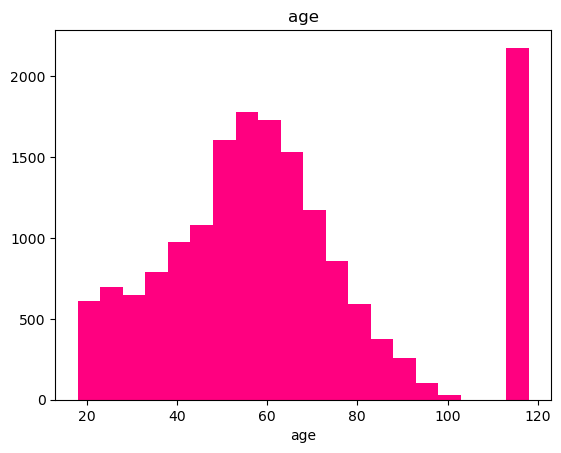

count      17000.000
mean    20167034.234
std        11677.500
min     20130729.000
5%      20141016.950
10%     20150831.000
20%     20160302.000
30%     20160818.000
40%     20170220.000
50%     20170802.000
60%     20171001.000
70%     20171130.000
80%     20180131.000
90%     20180429.000
95%     20180613.000
99%     20180718.000
max     20180726.000
Name: became_member_on, dtype: float64


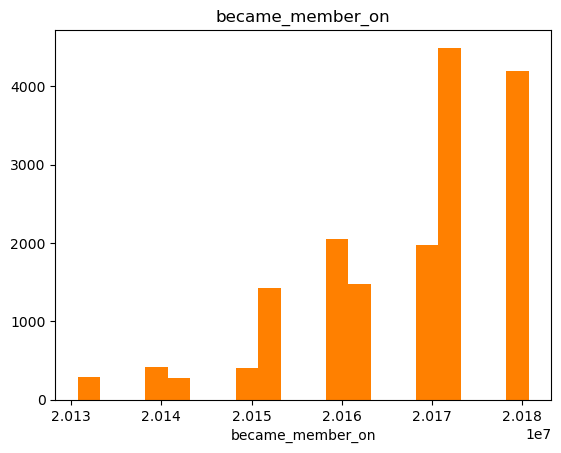

count    14825.000
mean     65404.992
std      21598.299
min      30000.000
5%       34000.000
10%      37000.000
20%      45000.000
30%      52000.000
40%      57000.000
50%      64000.000
60%      70000.000
70%      75000.000
80%      85000.000
90%      96000.000
95%     105000.000
99%     117000.000
max     120000.000
Name: customer_income, dtype: float64


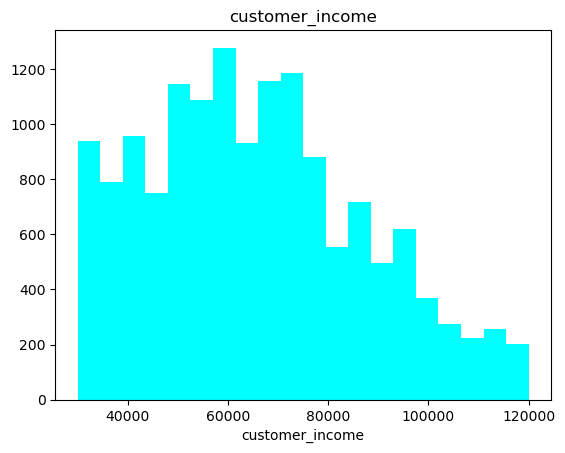

In [35]:
for col in num_cols:
    num_summary(profile, col, plot=True)

   gender  Ratio
M    8484 49.906
F    6129 36.053
O     212  1.247
##########################################


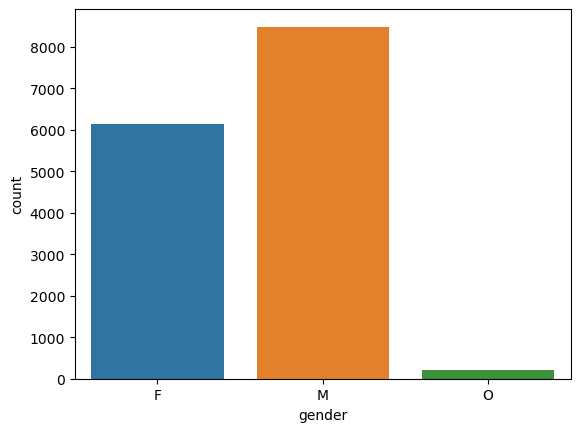

In [36]:
for col in cat_cols:
    cat_summary(profile, col, plot=True)

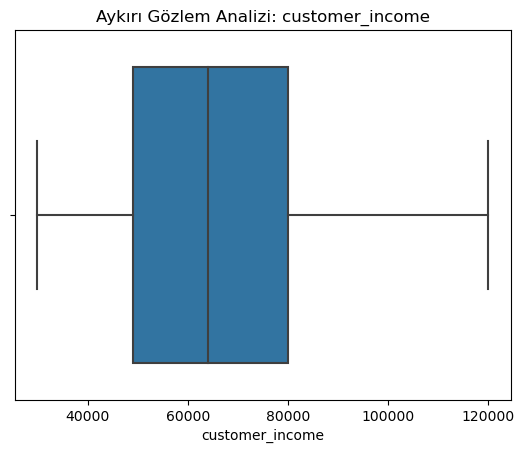

In [37]:
outlier_analysis(profile)

In [38]:
for col in num_cols:
    print(col, check_outlier(profile, col))

age True
became_member_on True
customer_income False


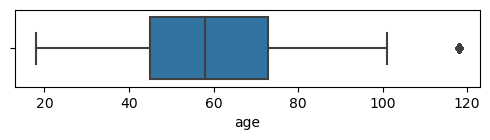

In [39]:
#yaş dağılımı
plt.figure(figsize=[6,1])
sns.boxplot(profile, x='age')
color = ['red']
sns.set_palette(sns.color_palette(color))

<Axes: xlabel='became_member_on'>

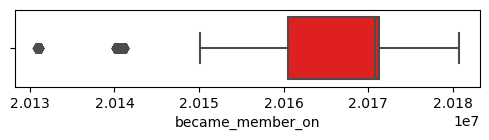

In [40]:
plt.figure(figsize=[6,1])
sns.boxplot(profile, x='became_member_on')

In [41]:
for col in num_cols:
    replace_with_thresholds(profile, col)

In [42]:
for col in num_cols:
    print(col, check_outlier(profile, col))

age False
became_member_on False
customer_income False


In [43]:
# Missing Values (Eksik Değerler)
profile.isnull().values.any()

True

In [44]:
profile.isnull().sum()

gender              2175
age                    0
customer_id            0
became_member_on       0
customer_income     2175
dtype: int64

In [45]:
#na_cols=eksik değerlerin olduğu kolonlar
na_cols = [col for col in profile.columns if profile[col].isnull().sum() > 0]
na_cols

['gender', 'customer_income']

In [46]:
missing_values_table(profile)

                 n_miss  ratio
gender             2175 12.790
customer_income    2175 12.790


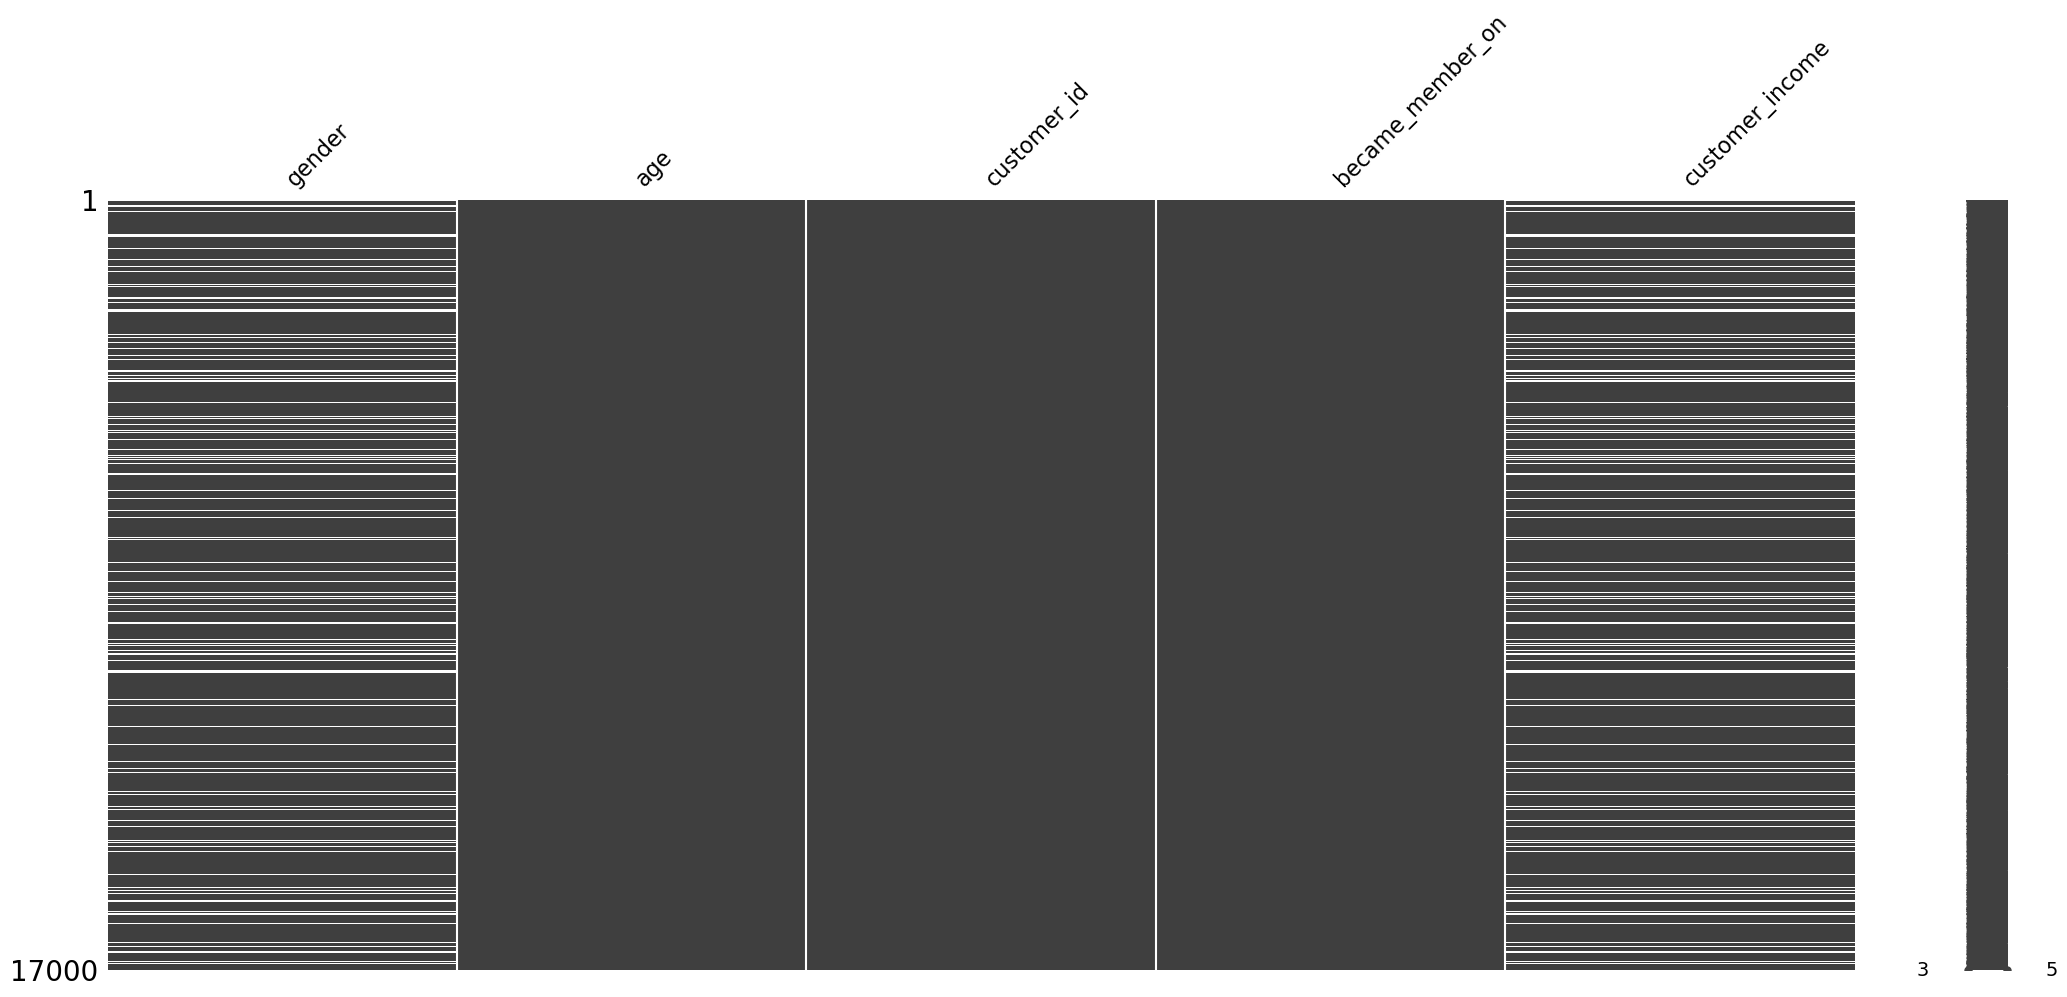

In [47]:
msno.matrix(profile)
plt.show()

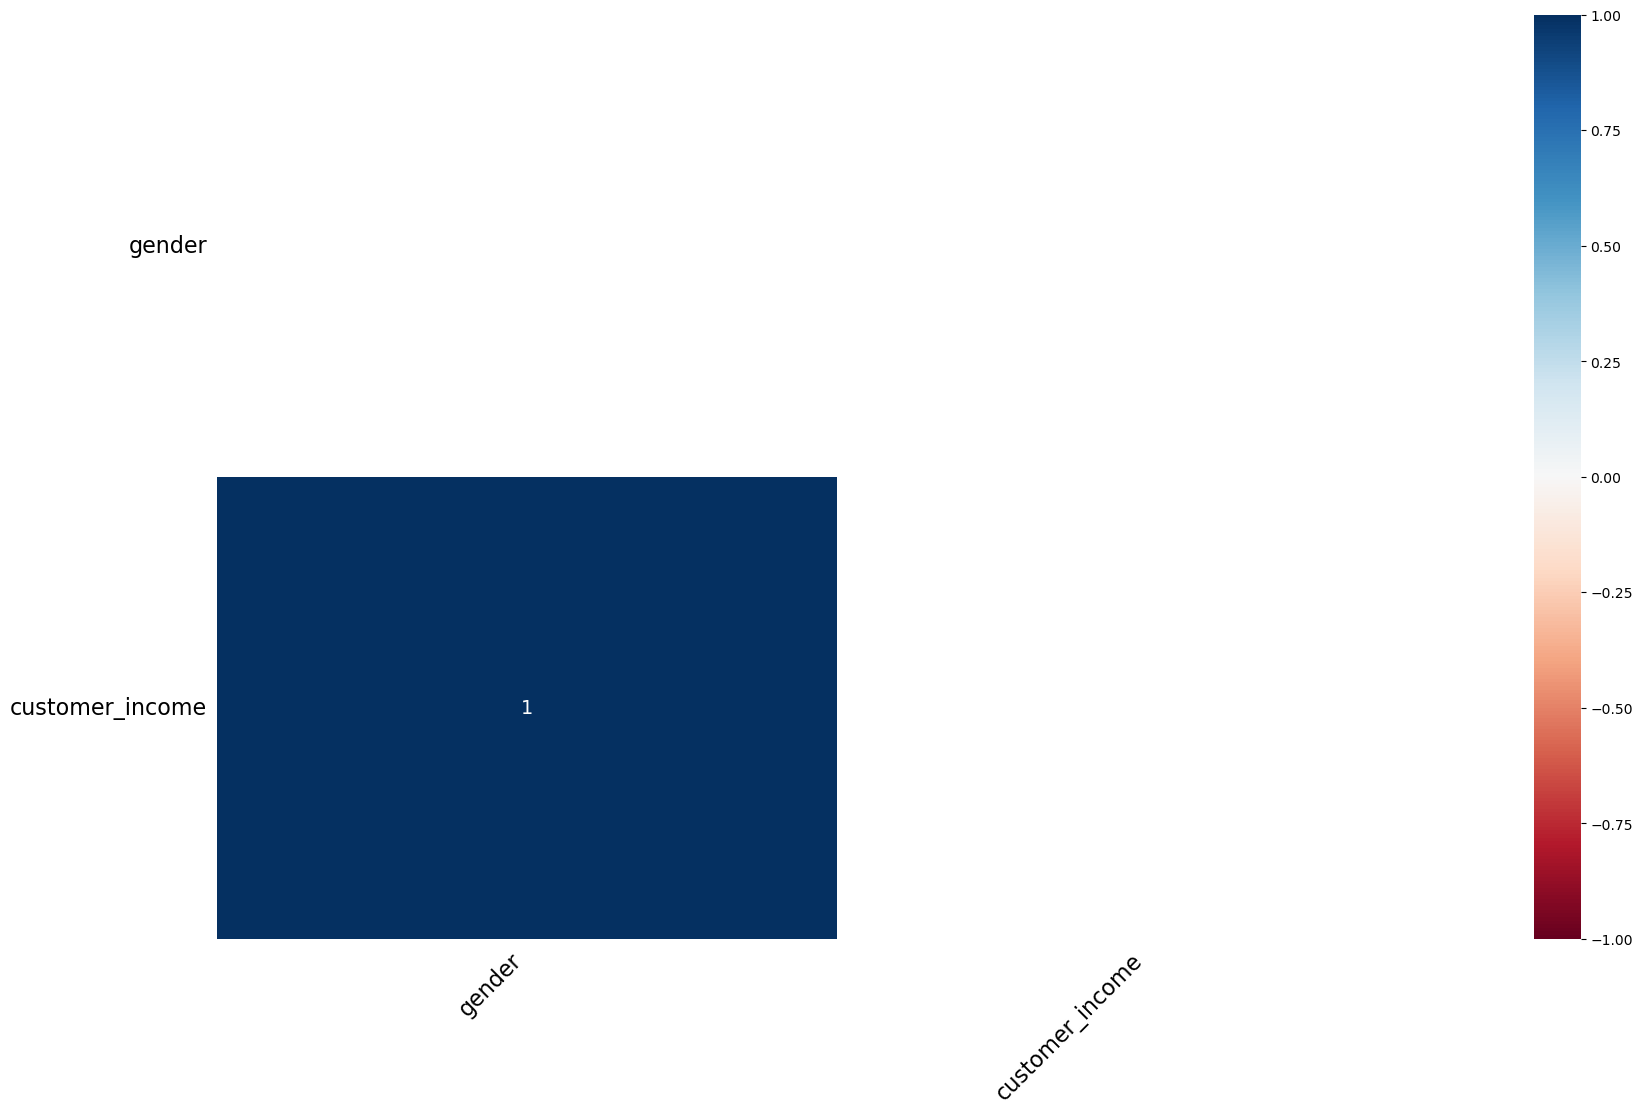

In [48]:
msno.heatmap(profile)
plt.show()

In [49]:
#Eksik Değer Problemini Çözme
profile.dropna(inplace=True)

profile.isnull().values.any()

False

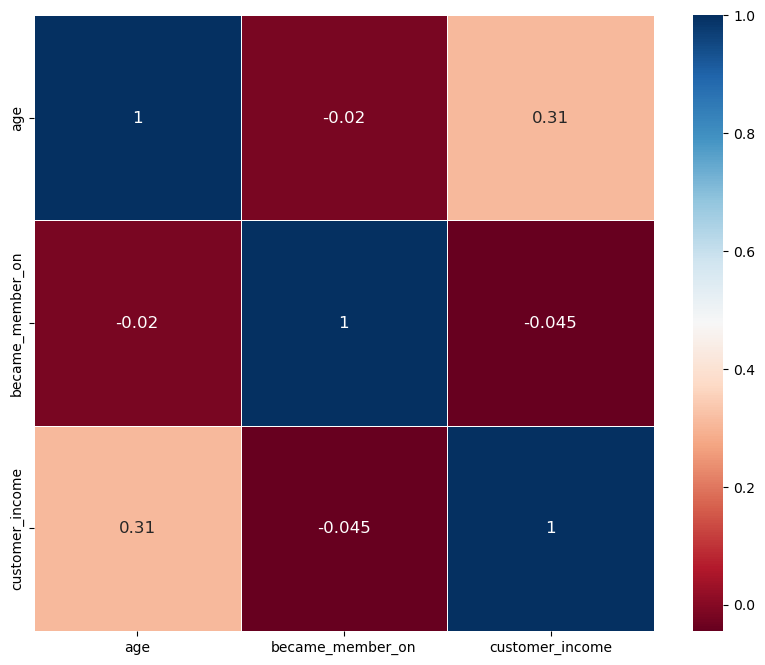

In [50]:
correlation_matrix(profile, num_cols)

In [51]:
#Change datetype of bacame_member_on column
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format = '%Y%m%d',  errors='coerce')   
#Encode the year values
profile['membership_year'] = profile['became_member_on'].apply(lambda elem: elem.year)

profile = profile.dropna(subset=['membership_year'])
profile['membership_year']= profile['membership_year'].astype(int)

membership_year = pd.get_dummies(profile['membership_year'])

profile["customer_income"] = profile["customer_income"].astype(int)

In [52]:
profile.head(5)

gender  age                       customer_id became_member_on  customer_income  membership_year
1       F   55  0610b486422d4921ae7d2bf64640c50b       2017-07-15           112000             2017
3       F   75  78afa995795e4d85b5d9ceeca43f5fef       2017-05-09           100000             2017
5       M   68  e2127556f4f64592b11af22de27a7932       2018-04-26            70000             2018
8       M   65  389bc3fa690240e798340f5a15918d5c       2018-02-09            53000             2018
12      M   58  2eeac8d8feae4a8cad5a6af0499a211d       2017-11-11            51000             2017

In [53]:
 #Group the Salary ranges
sal_labels = ['Under $50K','$(50,000-74,999)','$(75,000-99,999)', '$100K+']
    
profile['customer_income_range'] = pd.cut(profile['customer_income'], bins=[1, 49999, 74999, 99999, 150000] , 
                                  labels=sal_labels, include_lowest=True)


In [54]:
profile.head(2)

gender  age                       customer_id became_member_on  customer_income  membership_year customer_income_range
1      F   55  0610b486422d4921ae7d2bf64640c50b       2017-07-15           112000             2017                $100K+
3      F   75  78afa995795e4d85b5d9ceeca43f5fef       2017-05-09           100000             2017                $100K+

In [55]:
#Yaşları gruplandıralım
def age_to_category(age):
    if age >= 18 and age <= 25:
        return 'Genç'
    elif age >= 26 and age <= 45:
        return 'Genç Yetişkin'
    elif age >= 46 and age <= 59:
        return 'Son Yetişkin'
    else:
        return 'Yaşlı'
    
profile['age_category'] = profile['age'].apply(age_to_category)

In [56]:
profile.head(4)

gender  age                       customer_id became_member_on  customer_income  membership_year customer_income_range  age_category
1      F   55  0610b486422d4921ae7d2bf64640c50b       2017-07-15           112000             2017                $100K+  Son Yetişkin
3      F   75  78afa995795e4d85b5d9ceeca43f5fef       2017-05-09           100000             2017                $100K+         Yaşlı
5      M   68  e2127556f4f64592b11af22de27a7932       2018-04-26            70000             2018      $(50,000-74,999)         Yaşlı
8      M   65  389bc3fa690240e798340f5a15918d5c       2018-02-09            53000             2018      $(50,000-74,999)         Yaşlı

### 2.3. EDA for Transcript

In [57]:
check_df(transcript)

############# SHAPE #############
(306534, 5)
############# TYPES #############
Unnamed: 0     int64
person        object
event         object
value         object
time           int64
dtype: object
############# HEAD #############
   Unnamed: 0                            person           event                                             value  time
0           0  78afa995795e4d85b5d9ceeca43f5fef  offer received  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}     0
1           1  a03223e636434f42ac4c3df47e8bac43  offer received  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0
2           2  e2127556f4f64592b11af22de27a7932  offer received  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}     0
3           3  8ec6ce2a7e7949b1bf142def7d0e0586  offer received  {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}     0
4           4  68617ca6246f4fbc85e91a2a49552598  offer received  {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}     0
############# TAİL #############
        Unnamed

In [58]:
transcript.drop("Unnamed: 0", axis=1, inplace=True)

In [59]:
transcript.head(3)

person           event                                             value  time
0  78afa995795e4d85b5d9ceeca43f5fef  offer received  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}     0
1  a03223e636434f42ac4c3df47e8bac43  offer received  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0
2  e2127556f4f64592b11af22de27a7932  offer received  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}     0

In [60]:
new_col_transcript = {'person': 'customer_id'}
transcript = transcript.rename(columns= new_col_transcript )

In [61]:
transcript.head(2)

customer_id           event                                             value  time
0  78afa995795e4d85b5d9ceeca43f5fef  offer received  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}     0
1  a03223e636434f42ac4c3df47e8bac43  offer received  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0

In [62]:
transcript.sample(12)

customer_id           event                                             value  time
299113  cc7322218ad24de3aedc3123ec1c9e79     transaction                                 {'amount': 26.22}   678
290172  09367ecb1ea4474b8810b7ece379e60c     transaction                                 {'amount': 13.25}   648
182164  3c487d3686d642c687c14eaf3fbd0f15     transaction                                  {'amount': 17.9}   438
196717  c7271506fe0e40f69f01666994b1dcf5     transaction                                 {'amount': 15.45}   480
285101  ddc6402c0b3f48f285a93ad98c5496db     transaction                                  {'amount': 3.76}   630
69616   f030124b48cf4960b569da21d8aedb5b    offer viewed  {'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}   174
202992  63f1bfb1a79949bf9bc0d0b8b184fe4e  offer received  {'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}   504
31408   2ba2a88be5b349769ce3d3d411064075     transaction                                   {'amount': 7.1}    54
38308   846e2a96fe3249c4903cf333a15b08e5     transaction                                 {'amount': 18.06}    84
149713  d0ab05be7544435f935f13082b31ff0e     transaction                                 {'amount': 13.24}   402
74236   cee3677420e24b288b39394ecddf9825    offer viewed  {'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}   180
162847  84c428f8c96e47738f53fc6a63ecb776  offer received  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}   408

In [63]:
import ast
#value" sütunundaki stringleri gerçek sözlük yapısına dönüştürmek için --> ast.literal_eval()
# ".values()" metoduyla --> bu sözlükten "offer_id" değeri çıkartılır
transcript['offer_id'] = transcript['value'].apply(lambda elem: list(ast.literal_eval(elem).values())[0])

In [64]:
transcript.head(2)

customer_id           event                                             value  time                          offer_id
0  78afa995795e4d85b5d9ceeca43f5fef  offer received  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}     0  9b98b8c7a33c4b65b9aebfe6a799e6d9
1  a03223e636434f42ac4c3df47e8bac43  offer received  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0  0b1e1539f2cc45b7b9fa7c272da2e1d7

In [65]:
transcript['amount'] = transcript['value'].apply(lambda elem: ast.literal_eval(elem).get('amount')if isinstance(elem, str) and 'amount' in elem else None)

In [66]:
transcript.sample(4)

customer_id           event                                             value  time                          offer_id  amount
1635    ca98c3611fb044e581ad34f2b4bcf1f6  offer received  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0  0b1e1539f2cc45b7b9fa7c272da2e1d7     NaN
124122  75847bb70727423b9c198191391761e4    offer viewed  {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}   336  fafdcd668e3743c1bb461111dcafc2a4     NaN
137860  9ebe696078b742b389f486bd3a98ca56     transaction                                   {'amount': 1.5}   366                             1.500   1.500
155452  83fdc79d9f0b418585987414dcdab348  offer received  {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}   408  fafdcd668e3743c1bb461111dcafc2a4     NaN

In [67]:
mean_amount = transcript['amount'].mean()

# ortalamaları ile doldur
transcript['amount'].fillna(mean_amount, inplace=True)

In [68]:
transcript.sample(5)

customer_id            event                                              value  time                          offer_id  amount
223929  5fc8181b4b6646df8f4c9f22f0cf0f63      transaction                                   {'amount': 4.92}   516                             4.920   4.920
137330  f3b303726eba48edb0f89740422cfb8d  offer completed  {'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...   360  f19421c1d4aa40978ebb69ca19b0e20d  12.777
222425  5ce485cd9a894815aeee59210dd61b5c      transaction                                   {'amount': 8.95}   516                             8.950   8.950
267526  929464b411144357844a637642af2e2b      transaction                                  {'amount': 25.22}   588                            25.220  25.220
275795  e57d16caa8ab40c4ae2d97223b6a6d31      transaction                                  {'amount': 21.79}   606                            21.790  21.790

In [69]:
cat_cols, num_cols, cat_but_car = grab_col_names(transcript)

Observations: 306534
Variables: 6
cat_cols: 1
num_cols: 2
cat_but_car: 3
num_but_cat: 0


count   306534.000
mean       366.383
std        200.326
min          0.000
5%           0.000
10%         48.000
20%        168.000
30%        234.000
40%        336.000
50%        408.000
60%        444.000
70%        504.000
80%        576.000
90%        606.000
95%        648.000
99%        702.000
max        714.000
Name: time, dtype: float64


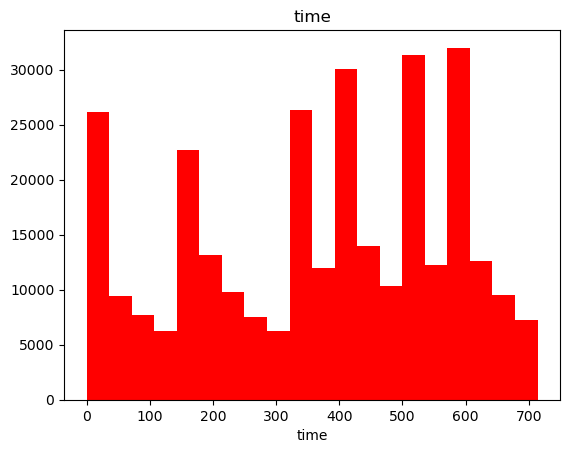

count   306534.000
mean        12.777
std         20.367
min          0.050
5%           1.180
10%          2.380
20%          6.880
30%         12.777
40%         12.777
50%         12.777
60%         12.777
70%         12.777
80%         12.777
90%         19.240
95%         24.810
99%         34.770
max       1062.280
Name: amount, dtype: float64


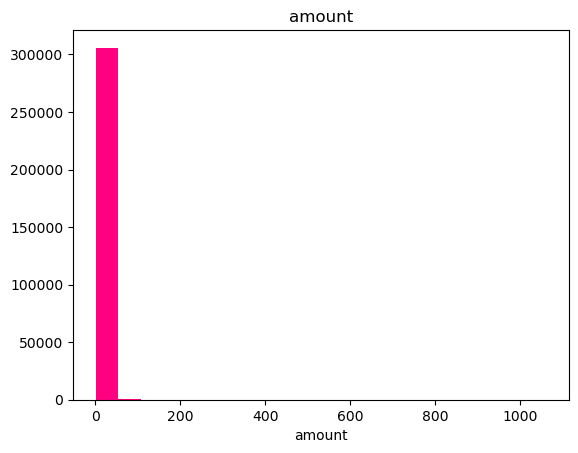

In [70]:
for col in num_cols:
    num_summary(transcript, col, plot=True)

                  event  Ratio
transaction      138953 45.330
offer received    76277 24.884
offer viewed      57725 18.832
offer completed   33579 10.954
##########################################


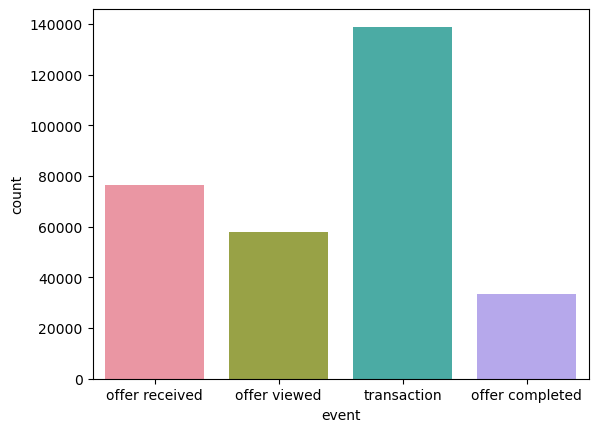

In [71]:
for col in cat_cols:
    cat_summary(transcript, col, plot=True)

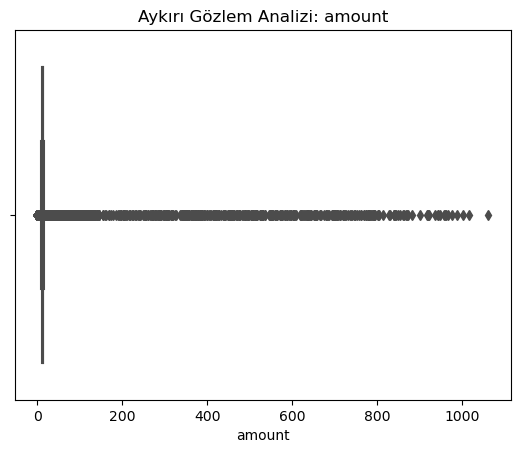

In [72]:
outlier_analysis(transcript)

In [73]:
for col in num_cols:
    print(col, check_outlier(transcript, col))

time False
amount True


In [74]:
# Missing Values (Eksik Değerler)
transcript.isnull().values.any()

False

In [75]:
transcript.head(2)

customer_id           event                                             value  time                          offer_id  amount
0  78afa995795e4d85b5d9ceeca43f5fef  offer received  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}     0  9b98b8c7a33c4b65b9aebfe6a799e6d9  12.777
1  a03223e636434f42ac4c3df47e8bac43  offer received  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0  0b1e1539f2cc45b7b9fa7c272da2e1d7  12.777

In [76]:
#profiledaki id ile transcripteki id ler eşleşiyor mu?
select_data = transcript["customer_id"].isin(profile["customer_id"])
#eşleşiyorsa bunları eşle.
transcript = transcript[select_data]

In [77]:
#time saat bazında onu gün bazına çevir
transcript['time'] = transcript['time'] // 24   
transcript = transcript.rename(columns={'time': 'time_in_days'})

In [78]:
transcript.head(3)

customer_id           event                                             value  time_in_days                          offer_id  amount
0  78afa995795e4d85b5d9ceeca43f5fef  offer received  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}             0  9b98b8c7a33c4b65b9aebfe6a799e6d9  12.777
2  e2127556f4f64592b11af22de27a7932  offer received  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}             0  2906b810c7d4411798c6938adc9daaa5  12.777
5  389bc3fa690240e798340f5a15918d5c  offer received  {'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}             0  f19421c1d4aa40978ebb69ca19b0e20d  12.777

## 3. Future Engineering & Visualization

In [79]:
#offer_id bazında birleştir
offers_df= pd.merge(transcript, portfolio, left_on='offer_id', right_on='offer_id', how='inner')
offers_df.head(2)

customer_id           event                                             value  time_in_days                          offer_id  amount offer_type  offer_difficulty  offer_duration  web  email  mobile  social
0  78afa995795e4d85b5d9ceeca43f5fef  offer received  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}             0  9b98b8c7a33c4b65b9aebfe6a799e6d9  12.777       bogo             5.000               7    1      1       1       0
1  ebe7ef46ea6f4963a7dd49f501b26779  offer received  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}             0  9b98b8c7a33c4b65b9aebfe6a799e6d9  12.777       bogo             5.000               7    1      1       1       0

In [80]:
profile.head(2)

gender  age                       customer_id became_member_on  customer_income  membership_year customer_income_range  age_category
1      F   55  0610b486422d4921ae7d2bf64640c50b       2017-07-15           112000             2017                $100K+  Son Yetişkin
3      F   75  78afa995795e4d85b5d9ceeca43f5fef       2017-05-09           100000             2017                $100K+         Yaşlı

In [81]:
#customer_id bazında birleştir
df= pd.merge(offers_df, profile, left_on='customer_id', right_on='customer_id', how='inner')
df.head(2)

customer_id           event                                             value  time_in_days                          offer_id  amount offer_type  offer_difficulty  offer_duration  web  email  mobile  social gender  age became_member_on  customer_income  membership_year customer_income_range age_category
0  78afa995795e4d85b5d9ceeca43f5fef  offer received  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}             0  9b98b8c7a33c4b65b9aebfe6a799e6d9  12.777       bogo             5.000               7    1      1       1       0      F   75       2017-05-09           100000             2017                $100K+        Yaşlı
1  78afa995795e4d85b5d9ceeca43f5fef    offer viewed  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}             0  9b98b8c7a33c4b65b9aebfe6a799e6d9  12.777       bogo             5.000               7    1      1       1       0      F   75       2017-05-09           100000             2017                $100K+        Yaşlı

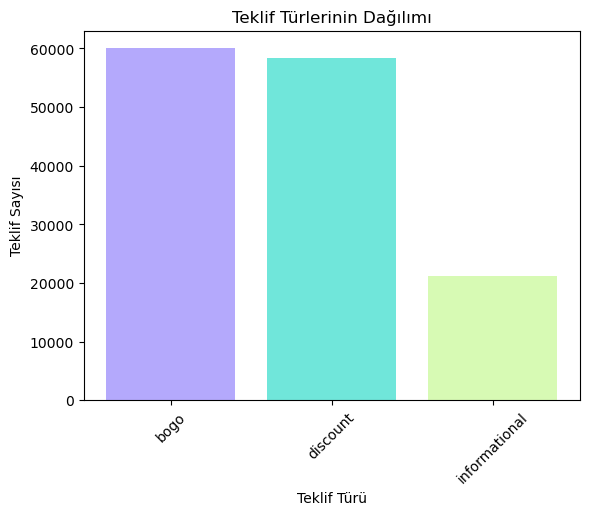

In [82]:
colors = ['#B4A9FC', '#70E6DA', '#D7FAB4', '#E3CB98', '#FCADA9', '#FFC58A', '#E3E176','#E65186']

#Teklif Türlerin Dağılımı

offer_type_counts = df['offer_type'].value_counts()
plt.bar(offer_type_counts.index, offer_type_counts.values, color=colors)
plt.xlabel('Teklif Türü')
plt.ylabel('Teklif Sayısı')
plt.title('Teklif Türlerinin Dağılımı')
plt.xticks(rotation=45)
plt.show()


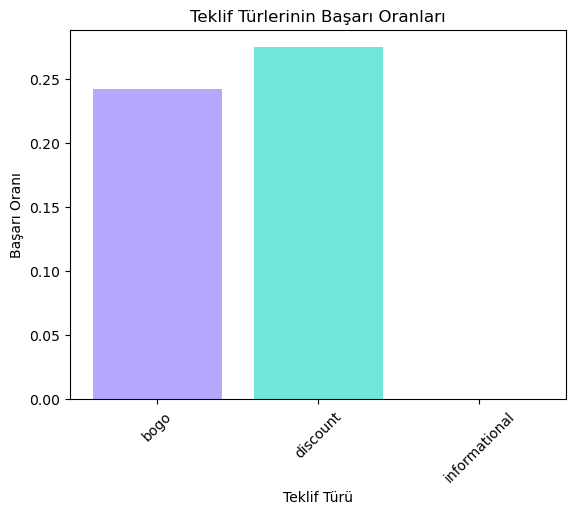

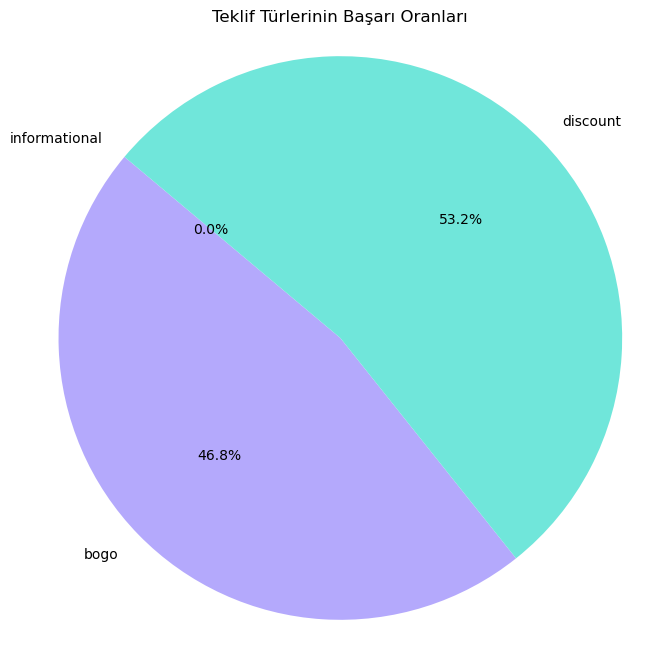

In [83]:
#Teklif türlerinin başarı oranları sütun grafiği
offer_success_rate = df.groupby('offer_type')['event'].apply(lambda x: (x == 'offer completed').mean())
plt.bar(offer_success_rate.index, offer_success_rate.values, color=colors)
plt.xlabel('Teklif Türü')
plt.ylabel('Başarı Oranı')
plt.title('Teklif Türlerinin Başarı Oranları')
plt.xticks(rotation=45)
plt.show()

#pasta grafiği
plt.figure(figsize=(8, 8))
plt.pie(offer_success_rate, labels=offer_success_rate.index, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Teklif Türlerinin Başarı Oranları')
plt.axis('equal')  # Daireyi yuvarlak yap
plt.show()


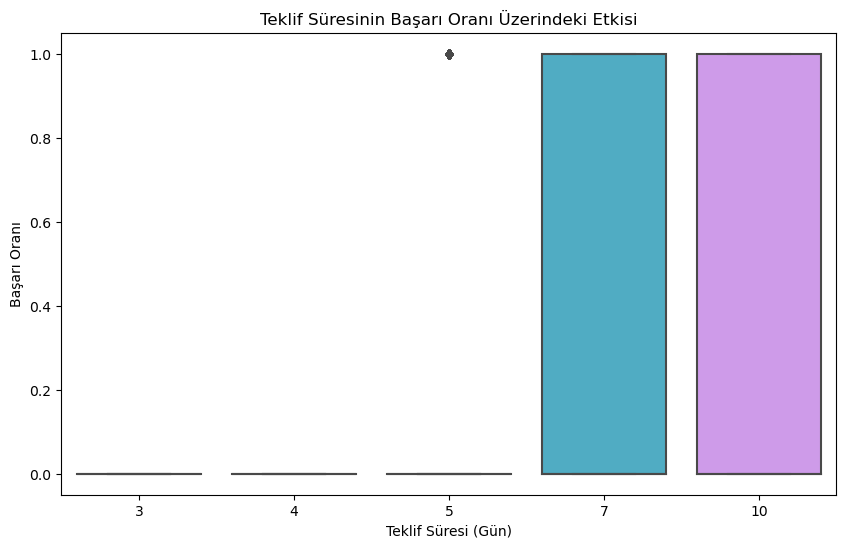

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt

# Başarı oranlarını hesapla
df['offer completed'] = df['event'].apply(lambda x: 1 if x == 'offer completed' else 0)
offer_success_rate = df.groupby('offer_duration')['offer completed'].mean()

# Teklif Süresinin Etkisi için Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='offer_duration', y='offer completed', data=df)
plt.xlabel('Teklif Süresi (Gün)')
plt.ylabel('Başarı Oranı')
plt.title('Teklif Süresinin Başarı Oranı Üzerindeki Etkisi')
plt.show()


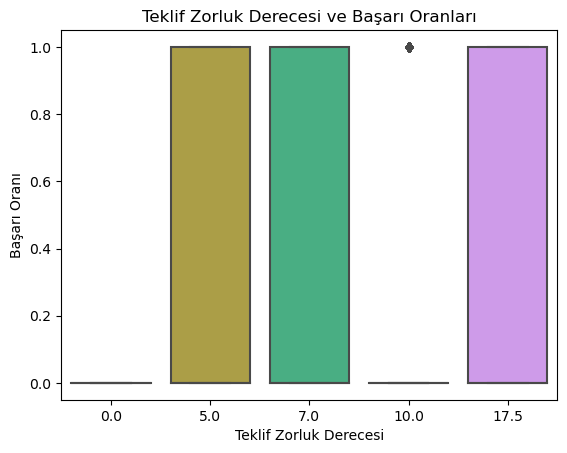

In [85]:
#Teklif zorluk derecesi ve tamamlanma oranları
sns.boxplot(x='offer_difficulty', y='offer completed', data=df)
plt.xlabel('Teklif Zorluk Derecesi')
plt.ylabel('Başarı Oranı')
plt.title('Teklif Zorluk Derecesi ve Başarı Oranları')
plt.show()


In [86]:
df.head(2)

customer_id           event                                             value  time_in_days                          offer_id  amount offer_type  offer_difficulty  offer_duration  web  email  mobile  social gender  age became_member_on  customer_income  membership_year customer_income_range age_category  offer completed
0  78afa995795e4d85b5d9ceeca43f5fef  offer received  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}             0  9b98b8c7a33c4b65b9aebfe6a799e6d9  12.777       bogo             5.000               7    1      1       1       0      F   75       2017-05-09           100000             2017                $100K+        Yaşlı                0
1  78afa995795e4d85b5d9ceeca43f5fef    offer viewed  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}             0  9b98b8c7a33c4b65b9aebfe6a799e6d9  12.777       bogo             5.000               7    1      1       1       0      F   75       2017-05-09           100000             2017                $100K+        Yaşlı                0

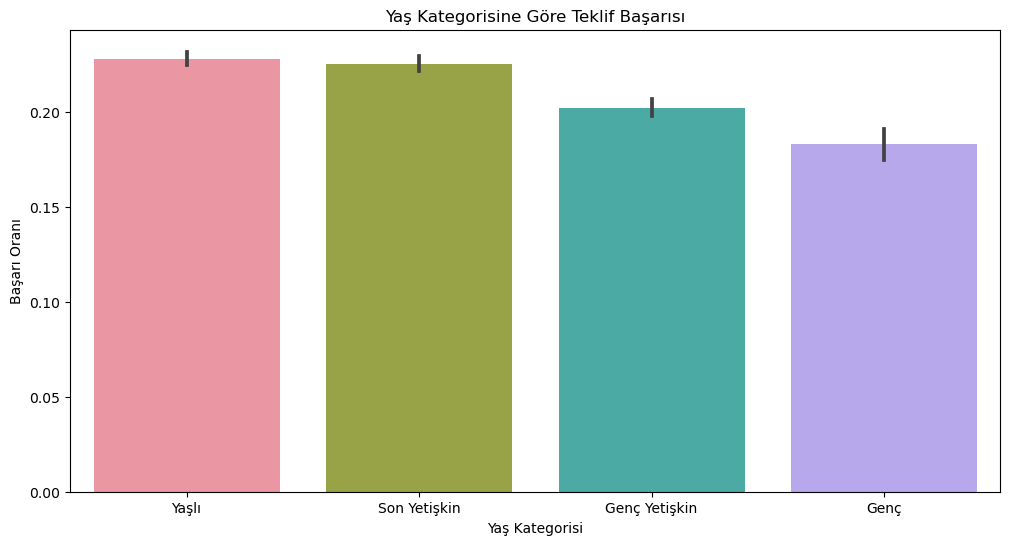

In [87]:
#müşterinin yaş kategorisine göre tamamlanma oranları
plt.figure(figsize=(12, 6))
sns.barplot(x='age_category', y='offer completed', data=df)
plt.xlabel('Yaş Kategorisi')
plt.ylabel('Başarı Oranı')
plt.title('Yaş Kategorisine Göre Teklif Başarısı')
plt.show()


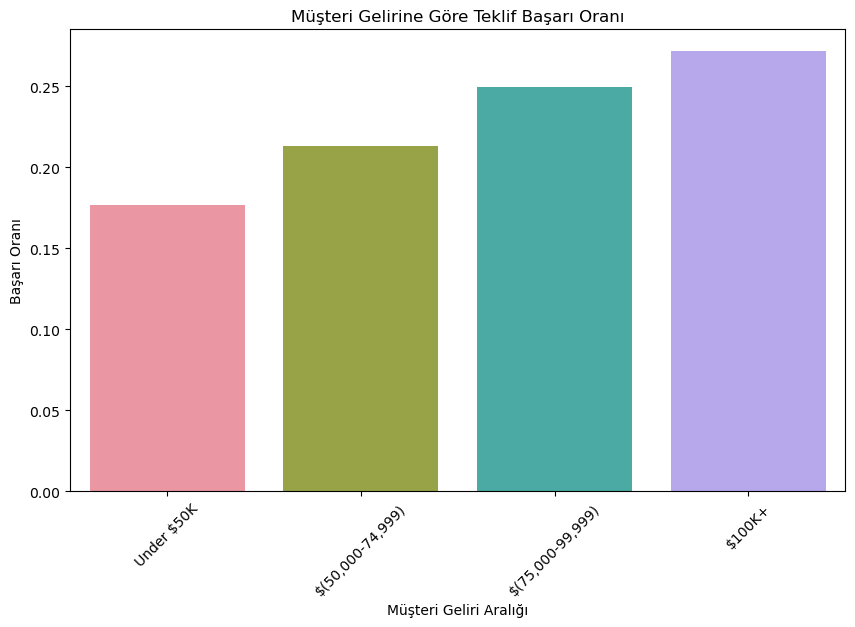

In [88]:
income_success_rate = df.groupby('customer_income_range')['offer completed'].mean()

# Müşteri gelirine göre başarı oranlarını gösteren bar grafiği
plt.figure(figsize=(10, 6))
sns.barplot(x=income_success_rate.index, y=income_success_rate.values)
plt.xlabel('Müşteri Geliri Aralığı')
plt.ylabel('Başarı Oranı')
plt.title('Müşteri Gelirine Göre Teklif Başarı Oranı')
plt.xticks(rotation=45)
plt.show()

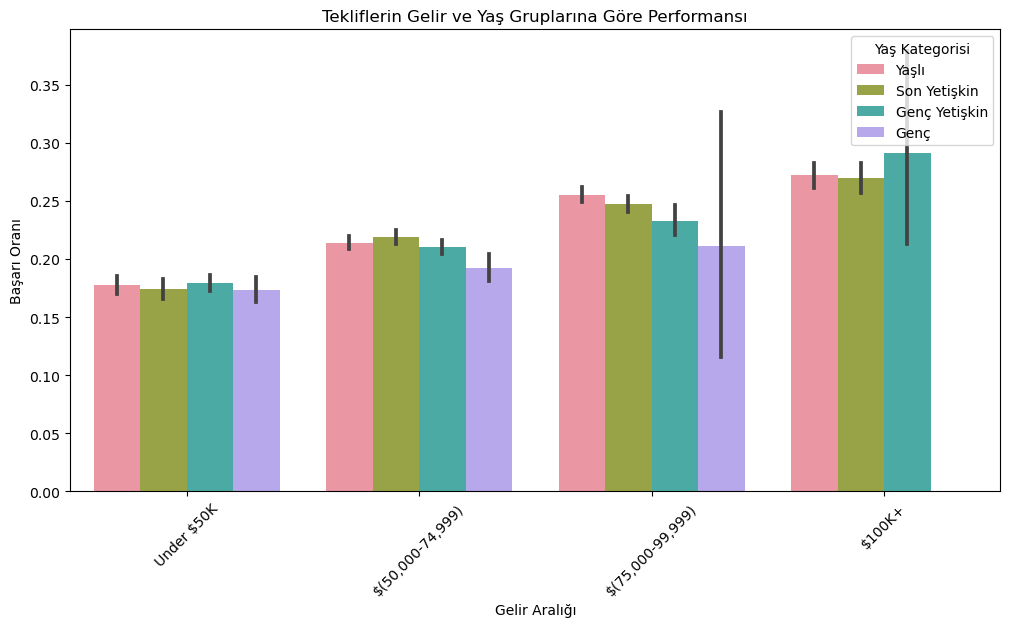

In [89]:
#tekliflerin gelir ve yaş gruplarına göre performansı
plt.figure(figsize=(12, 6))
sns.barplot(x='customer_income_range', y='offer completed', hue='age_category', data=df)
plt.xlabel('Gelir Aralığı')
plt.ylabel('Başarı Oranı')
plt.title('Tekliflerin Gelir ve Yaş Gruplarına Göre Performansı')
plt.xticks(rotation=45)
plt.legend(title='Yaş Kategorisi', loc='upper right')
plt.show()


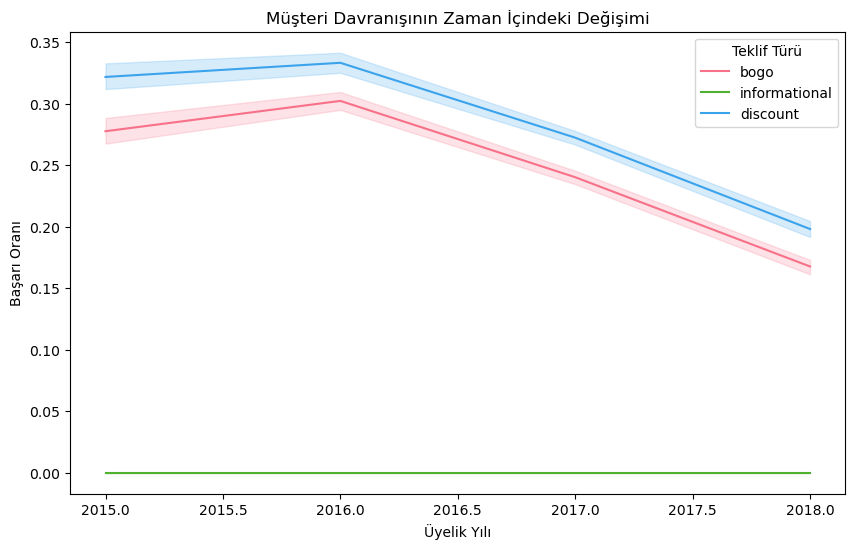

In [90]:
#müşteri davranışlarının zaman içindeki değişimi
df['became_member_on'] = pd.to_datetime(df['became_member_on'])
df['membership_year'] = df['became_member_on'].dt.year

plt.figure(figsize=(10, 6))
sns.lineplot(x='membership_year', y='offer completed', hue='offer_type', data=df)
plt.xlabel('Üyelik Yılı')
plt.ylabel('Başarı Oranı')
plt.title('Müşteri Davranışının Zaman İçindeki Değişimi')
plt.legend(title='Teklif Türü')
plt.show()


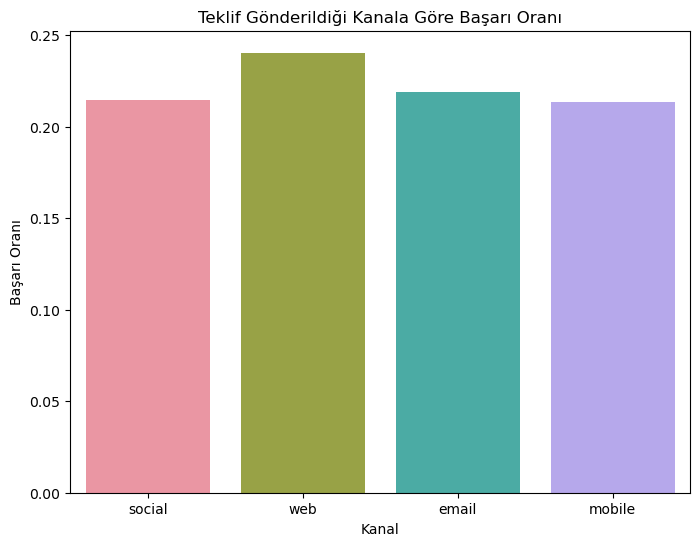

In [91]:
channel_list = ['social', 'web', 'email', 'mobile']
channel_success_rate = {}

for channel in channel_list:
    success_rate = df[df[channel] == 1]['offer completed'].mean()
    channel_success_rate[channel] = success_rate

# Teklif gönderildiği kanala göre başarı oranlarını gösteren bar grafiği
plt.figure(figsize=(8, 6))
sns.barplot(x=list(channel_success_rate.keys()), y=list(channel_success_rate.values()))
plt.xlabel('Kanal')
plt.ylabel('Başarı Oranı')
plt.title('Teklif Gönderildiği Kanala Göre Başarı Oranı')
plt.show()

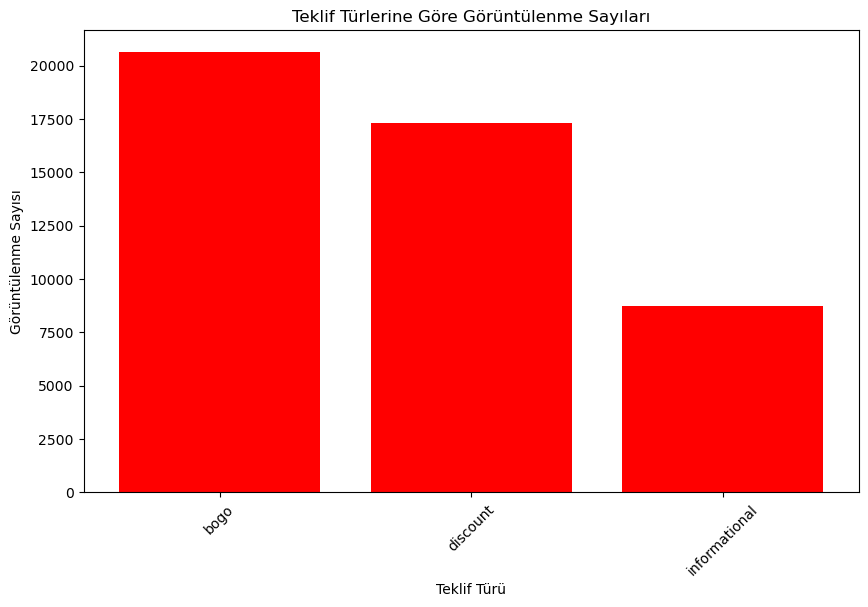

In [92]:
# Teklif türlerine göre görüntülenme sayılarını hesaplayın
offer_type_counts = df[df['event'] == 'offer viewed']['offer_type'].value_counts()

# Çubuk grafiğini çizin
plt.figure(figsize=(10, 6))
plt.bar(offer_type_counts.index, offer_type_counts.values)
plt.xlabel('Teklif Türü')
plt.ylabel('Görüntülenme Sayısı')
plt.title('Teklif Türlerine Göre Görüntülenme Sayıları')
plt.xticks(rotation=45)
plt.show()

In [93]:
df.head(2)

customer_id           event                                             value  time_in_days                          offer_id  amount offer_type  offer_difficulty  offer_duration  web  email  mobile  social gender  age became_member_on  customer_income  membership_year customer_income_range age_category  offer completed
0  78afa995795e4d85b5d9ceeca43f5fef  offer received  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}             0  9b98b8c7a33c4b65b9aebfe6a799e6d9  12.777       bogo             5.000               7    1      1       1       0      F   75       2017-05-09           100000             2017                $100K+        Yaşlı                0
1  78afa995795e4d85b5d9ceeca43f5fef    offer viewed  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}             0  9b98b8c7a33c4b65b9aebfe6a799e6d9  12.777       bogo             5.000               7    1      1       1       0      F   75       2017-05-09           100000             2017                $100K+        Yaşlı                0

## 4. A/B Test
maaşa göre teklifleri tamamlama oranları arasında anlamlı bir ilişki var mı?

1. Hipotezleri Kur (neyi sınamak istiyorsan ona yönelik hipotez kur)
2. Varsayım Kontrolü
     - 1. Normallik Varsayımı
     - 2. Varyans Homojenliği
3. Hipotezin Uygulanması
      - 1. Varsayımlar sağlanıyorsa bağımsız iki örneklem t testi (parametrik test)
      - 2. Varsayımlar sağlanmıyorsa mannwhitneyu testi (non-parametrik test)
4. p-value değerine göre sonuçları yorumla


* Not:
- Normallik sağlanmıyorsa direk 2 numara. Varyans homojenliği sağlanmıyorsa 1 numaraya arguman girilir.
- Normallik incelemesi öncesi aykırı değer incelemesi ve düzeltmesi yapmak faydalı olabilir.


In [94]:
#tekliflerin başarı ile tamamlanıp tamamlanmadığının ortalamasına bakalım
df.groupby("offer completed").agg({"customer_income": "mean"})

customer_income
offer completed                 
0                      66053.115
1                      69857.372

In [95]:
#shapiro methodu= bir değişkenin dağılımının normal olup olmadığını test eder.

from scipy.stats import shapiro

completed_customers_income = df.loc[df["offer completed"] == 1, "customer_income"]

if len(completed_customers_income) >= 3:
    test_stat, pvalue = shapiro(completed_customers_income)
    print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))
else:
    print("Insufficient data points to perform the Shapiro-Wilk test.")


Test Stat = 0.9816, p-value = 0.0000


C:\Users\esman\anaconda3\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [96]:
completed_customers_income = df.loc[df["offer completed"] == 0, "customer_income"]

if len(completed_customers_income) >= 3:
    test_stat, pvalue = shapiro(completed_customers_income)
    print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))
else:
    print("Insufficient data points to perform the Shapiro-Wilk test.")


Test Stat = 0.9743, p-value = 0.0000


In [97]:
# H0: Varyanslar Homojendir
# H1: Varyanslar Homojen Değildir

# Varyans Homojenligi Varsayımı (levene testi kullanılır)
from scipy.stats import levene

sample1 = df.loc[df["offer completed"] == 1, "customer_income"].dropna()
sample2 = df.loc[df["offer completed"] == 0, "customer_income"].dropna()

# Perform Levene's test
test_stat, pvalue = levene(sample1, sample2)
print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))

Test Stat = 7.6425, p-value = 0.0057


In [98]:
# mannwhitneyu testi : non-parametrik 2 örneklem karşılaştırma testi
from scipy.stats import mannwhitneyu

offer_completed = df.loc[df["offer completed"].notnull(), "offer completed"]
customer_income = df.loc[df["customer_income"].notnull(), "customer_income"]

test_stat, pvalue = mannwhitneyu(offer_completed, customer_income)
print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))

Test Stat = 0.0000, p-value = 0.0000


Bu sonuca göre iki durum arasında anlamlı bir farklılık olduğu görülmektedir.

## 5. Customer Segmentation using RFM Analysis

In [99]:
df.head(2)

customer_id           event                                             value  time_in_days                          offer_id  amount offer_type  offer_difficulty  offer_duration  web  email  mobile  social gender  age became_member_on  customer_income  membership_year customer_income_range age_category  offer completed
0  78afa995795e4d85b5d9ceeca43f5fef  offer received  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}             0  9b98b8c7a33c4b65b9aebfe6a799e6d9  12.777       bogo             5.000               7    1      1       1       0      F   75       2017-05-09           100000             2017                $100K+        Yaşlı                0
1  78afa995795e4d85b5d9ceeca43f5fef    offer viewed  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}             0  9b98b8c7a33c4b65b9aebfe6a799e6d9  12.777       bogo             5.000               7    1      1       1       0      F   75       2017-05-09           100000             2017                $100K+        Yaşlı                0

In [100]:
df["amount"].sample(12)

52785    12.777
86321    12.777
97164    12.777
52721    12.777
127638   12.777
80473    12.777
79137    12.777
24206    12.777
4521     12.777
76650    12.777
82004    12.777
72009    12.777
Name: amount, dtype: float64

In [101]:
mean_amount = df['amount'].mean()
df['amount'].fillna(mean_amount, inplace=True)

In [102]:
# veri seti içinde işlem yapılan son tarih
df["became_member_on"].max()

Timestamp('2018-07-26 00:00:00')

In [103]:
#analiz yapılan tarih için (year, month, day)
import datetime as dt

today_date = dt.datetime(2018, 7, 28)

In [104]:
rfm_df = df.groupby('customer_id').agg( {'time_in_days': 'max' ,
                                         'amount': ['count', 'sum'] }).reset_index(col_level=1)
    
rfm_df.head(2)

time_in_days amount        
                        customer_id          max  count     sum
0  0009655768c64bdeb2e877511632db8f           24     12 153.328
1  0011e0d4e6b944f998e987f904e8c1e5           24     13 166.106

In [105]:
rfm_df.columns = ['customer_id' , 'time_in_days'  ,'Frequency', 'Monetary']

In [106]:
rfm_df = rfm_df.sort_values(['time_in_days', 'Frequency', 'Monetary'], ascending=False)

In [107]:
rfm_df['Recency']  = rfm_df['time_in_days'].max() - rfm_df['time_in_days']

In [108]:
rfm = rfm_df[['customer_id', 'Recency', 'Frequency', 'Monetary']]

In [109]:
rfm.sample(6)

customer_id  Recency  Frequency  Monetary
9866   b4360ed1ef1147d3acdc322dc98e0811        5         11   140.551
5696   68aa156c761e40bf8a0f8d859379c89d        4         12   153.328
1717   20e750ef548a41628be433e37b508b34        5         10   127.774
10153  b9950188abc7417c8c1ce93af735e762        5          7    89.441
3237   3bf266ed72ec4b73a84d8f7029f0fb72        5          4    51.109
6840   7dfe7355623a45988127c78ac7504bbc        3         12   153.328

#### 5.1. RFM Skorlarının Hesaplanması

In [110]:
rfm["recency_score"] = pd.cut(rfm["Recency"], 5, labels=[5,4,3,2,1], duplicates='drop',include_lowest=True)
rfm["monetary_score"] = pd.qcut(rfm["Monetary"], 5, labels=[1,2,3,4,5], duplicates='drop')
rfm["frequency_score"] = pd.qcut(rfm["Frequency"].rank(method = "first"), 5, labels=[1,2,3,4,5], duplicates='drop')

In [111]:
rfm.sample(3)

customer_id  Recency  Frequency  Monetary recency_score monetary_score frequency_score
9155  a704e150927f49a0ab88f152078f159d        3          8   102.219             5              2               2
3275  3c826c4141944d9aade15534216105f5        5          8   102.219             5              2               2
661   0c41798831f44abfbe474aba2ee0a802        3         10   127.774             5              3               3

In [112]:
rfm["RFM_SCORE"] = (rfm["recency_score"].astype(str) +
                    rfm["frequency_score"].astype(str))
rfm.head()

customer_id  Recency  Frequency  Monetary recency_score monetary_score frequency_score RFM_SCORE
6848   7e45faba0a8346379d0c296f1df8ae1d        0         18   229.992             5              5               5        55
7458   89939d40a29c4cec90827c6a370306a6        0         18   229.992             5              5               5        55
10378  bdfba75f0e0c4533b4b6b97fa37daa4f        0         18   229.992             5              5               5        55
467    08eae23115f745e6a388307d62261686        0         17   217.215             5              5               5        55
1181   1615981b0a114e42bc1b0f65b2ac4c8b        0         17   217.215             5              5               5        55

#### 5.2. RFM Segmentlerinin Oluşturulması ve Analizi

In [113]:
#RFM İSİMLENDİRİLMESİ
seg_map = {
    r"[1-2][1-2]" : "hibernating",
    r"[1-2][3-4]": "at_Risk",
    #birinci elemanında 1 ya da 2, ikinci elmanında 5 görürsen cant_loose isimlendirmesi yap
    r"[1-2]5": "cant_loose",
    r"3[1-2]": "about_to_sleep",
    #birinci elemanında 3, ikinci elemanında 3 görürsen neeed_attention isimlendirmesi yap.
    r"33": "need_attention",
    r"[3-4][4-5]": "loyal_customers",
    r"41": "promising",
    r"51": "new_customers",
    r"[4-5][2-3]": "potential_loyalists",
    r"5[4-5]": "champions",
}

In [114]:
rfm["segment"] = rfm["RFM_SCORE"].replace(seg_map, regex=True)
rfm.head()

customer_id  Recency  Frequency  Monetary recency_score monetary_score frequency_score RFM_SCORE    segment
6848   7e45faba0a8346379d0c296f1df8ae1d        0         18   229.992             5              5               5        55  champions
7458   89939d40a29c4cec90827c6a370306a6        0         18   229.992             5              5               5        55  champions
10378  bdfba75f0e0c4533b4b6b97fa37daa4f        0         18   229.992             5              5               5        55  champions
467    08eae23115f745e6a388307d62261686        0         17   217.215             5              5               5        55  champions
1181   1615981b0a114e42bc1b0f65b2ac4c8b        0         17   217.215             5              5               5        55  champions

In [115]:
rfm[["segment", "Recency", "Frequency", "Monetary"]].groupby("segment").agg(["mean", "count"])

Recency       Frequency       Monetary      
                       mean count      mean count     mean count
segment                                                         
about_to_sleep       12.976   337     5.608   337   71.659   337
champions             3.680  4951    13.253  4951  169.334  4951
hibernating          21.527    55     3.927    55   50.180    55
loyal_customers       7.473   603    12.071   603  154.239   603
need_attention       12.420    50     9.260    50  118.318    50
new_customers         4.094  1867     6.024  1867   76.972  1867
potential_loyalists   4.358  5389     9.157  5389  116.997  5389
promising             7.835   632     5.535   632   70.720   632

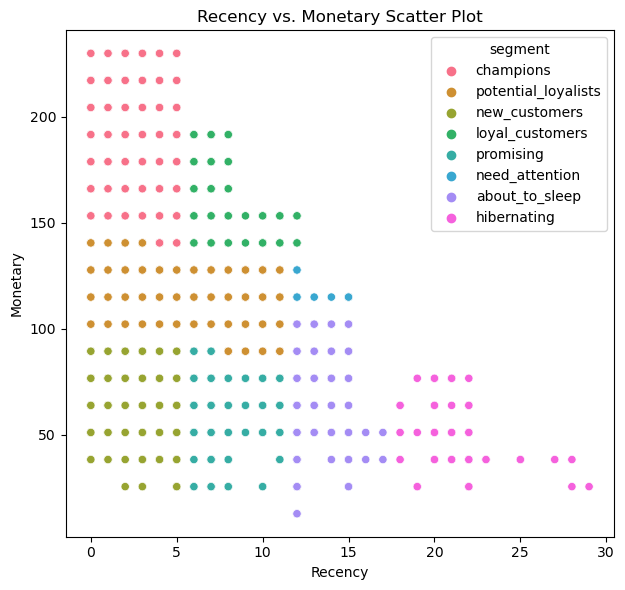

In [116]:
#Recency vs. Monetary Scatter Plot
colors = ['#ff0000', '#00ff00', '#0000ff', '#ffff00', '#ff00ff', '#00ffff',
              '#ff8000', '#8000ff', '#0080ff', '#ff0080', '#80ff00', '#00ff80']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(data=rfm, x="Recency", y="Monetary", hue="segment", color="colors")
plt.title("Recency vs. Monetary Scatter Plot")
plt.tight_layout()
plt.show()



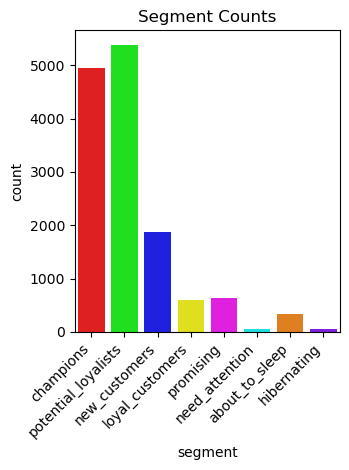

In [117]:
 #Segment Sayıları
plt.subplot(1, 2, 2)
sns.countplot(data=rfm, x="segment", palette= colors)
plt.title("Segment Counts")
plt.xticks(rotation=45, ha="right")
    
plt.tight_layout()
plt.show()

In [118]:
import plotly.express as px
#Recency
fig_recency = px.histogram(rfm, x="Recency", nbins=20, title="Recency")
fig_recency.show()

In [119]:
# Frequency
fig_frequency = px.histogram(rfm, x="Frequency", nbins=20, title="Frequency")
fig_frequency.show()

In [120]:
# Monetary
fig_monetary = px.histogram(rfm, x="Monetary", nbins=20, title="Monetary")
fig_monetary.show()

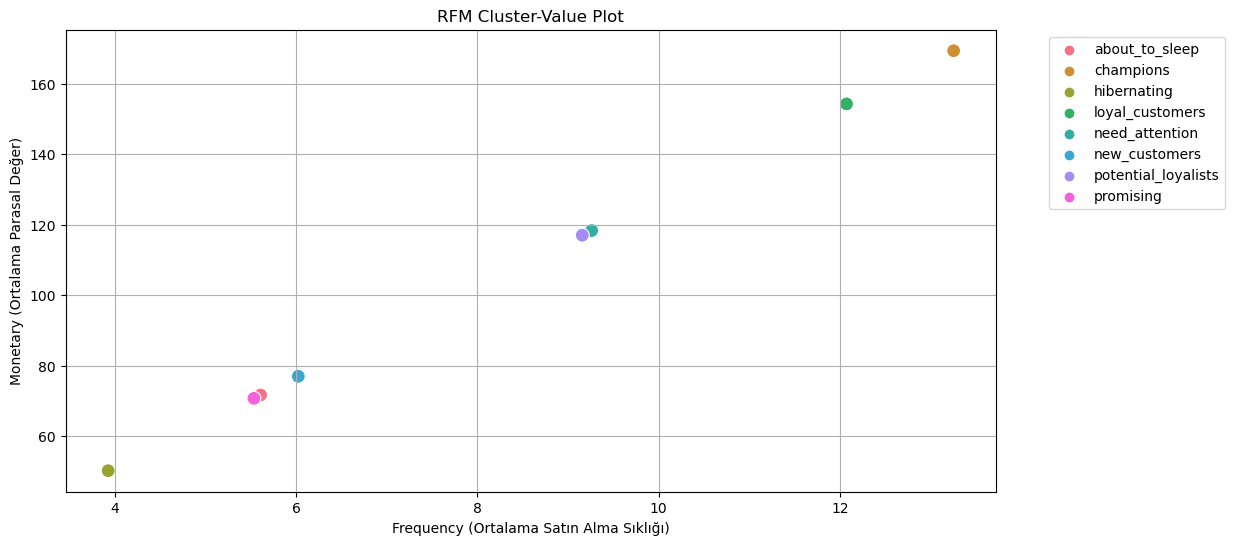

In [121]:
rfm_segment_value = rfm.groupby("segment").agg({"Monetary": "mean", "Frequency": "mean"}).reset_index()

plt.figure(figsize=(12, 6))
sns.scatterplot(data=rfm_segment_value, x="Frequency", y="Monetary", hue="segment", s=100)
plt.xlabel("Frequency (Ortalama Satın Alma Sıklığı)")
plt.ylabel("Monetary (Ortalama Parasal Değer)")
plt.title("RFM Cluster-Value Plot")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

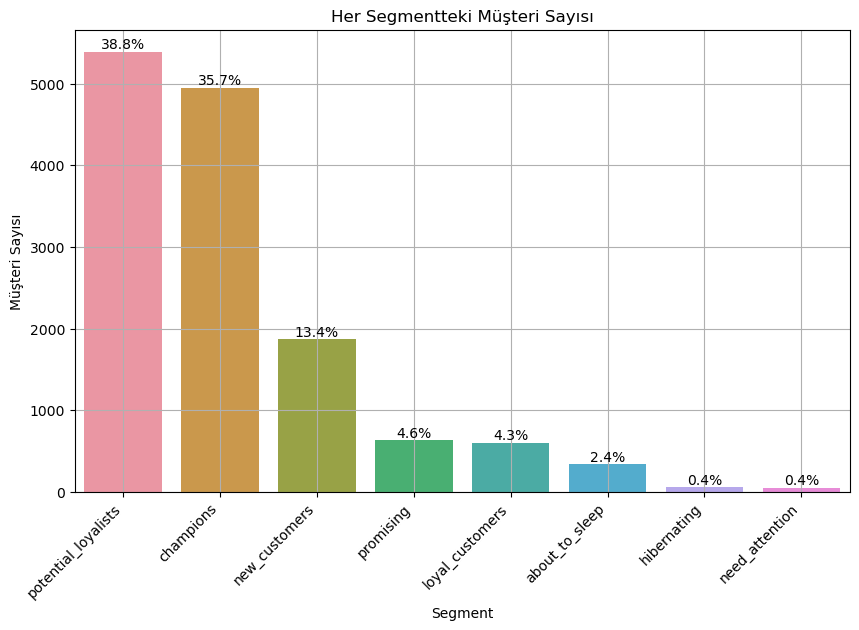

In [122]:
rfm_segment_counts = rfm["segment"].value_counts().reset_index()
rfm_segment_counts.columns = ["segment", "customer_count"]
total_customers = rfm_segment_counts["customer_count"].sum()
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=rfm_segment_counts, x="segment", y="customer_count")
plt.xlabel("Segment")
plt.ylabel("Müşteri Sayısı")
plt.title("Her Segmentteki Müşteri Sayısı")
plt.xticks(rotation=45, ha="right")
plt.grid(True)

for index, row in rfm_segment_counts.iterrows():
    percentage = (row["customer_count"] / total_customers) * 100
    plt.text(index, row["customer_count"], f"{percentage:.1f}%", ha="center", va="bottom")

plt.show()

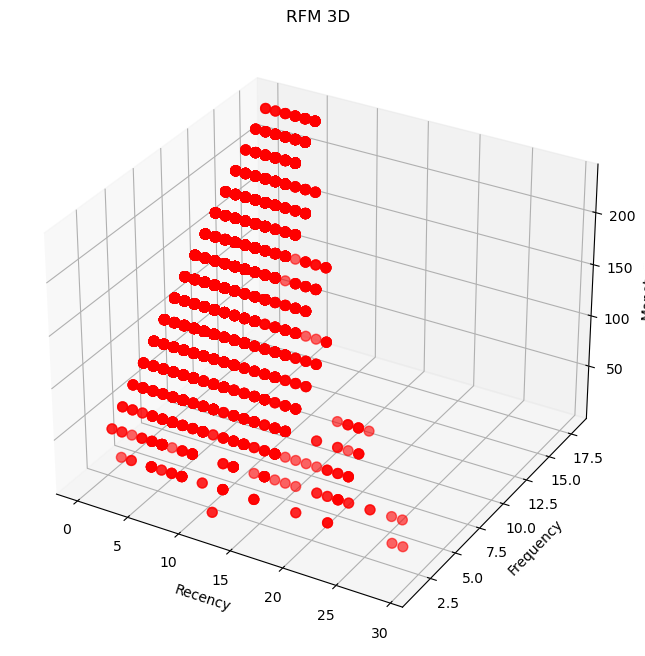

In [123]:
from mpl_toolkits.mplot3d import Axes3D

recency = rfm["Recency"]
frequency = rfm["Frequency"]
monetary = rfm["Monetary"]

# 3D grafik için
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(recency, frequency, monetary, s=50, alpha=0.6)

ax.set_xlabel("Recency")
ax.set_ylabel("Frequency")
ax.set_zlabel("Monetary")

plt.title("RFM 3D")

plt.show()

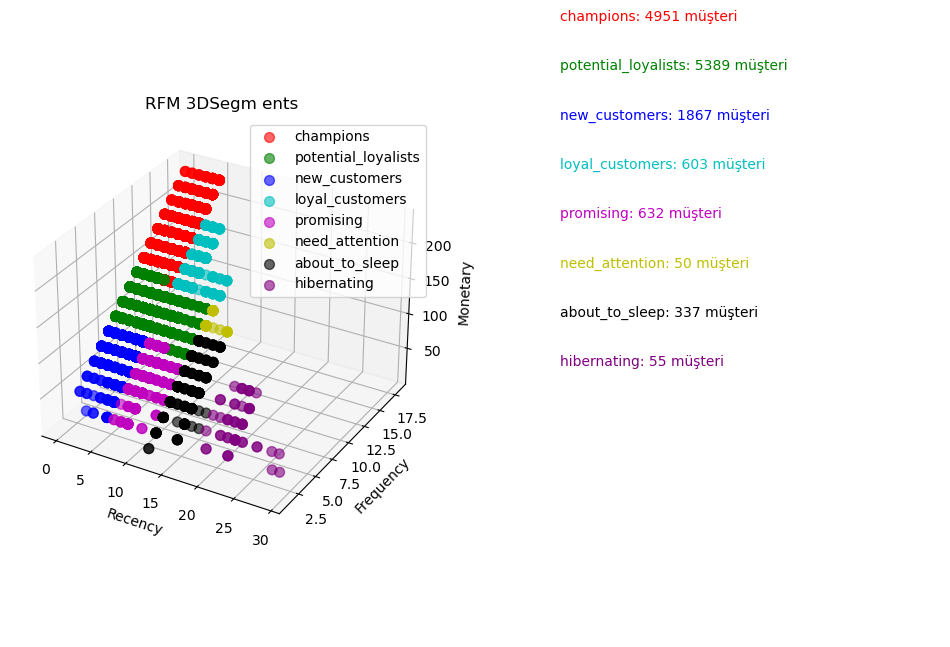

In [124]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(121, projection="3d")  
ax_legend = fig.add_subplot(122)  

# segmentler
segments = rfm["segment"].unique()
colors = ["r", "g", "b", "c", "m", "y", "k", "purple", "orange", "gray"]

for i, segment in enumerate(segments):
    segment_data = rfm[rfm["segment"] == segment]
    ax.scatter(segment_data["Recency"], segment_data["Frequency"], segment_data["Monetary"],
               s=50, alpha=0.6, c=colors[i], label=segment)
    # Segment açıklamaları
    ax_legend.text(0.1, 1 - (i * 0.08), f"{segment}: {segment_data.shape[0]} müşteri",
                   fontsize=10, color=colors[i], transform=ax_legend.transAxes)

ax.set_xlabel("Recency")
ax.set_ylabel("Frequency")
ax.set_zlabel("Monetary")

ax.set_title("RFM 3DSegm ents")
ax.legend(loc="upper right")

ax_legend.axis("off")

plt.show()

In [125]:
#yeni bir df oluştur (içine segmentlere ayrılan müşteriler atanacak)
new_df =pd.DataFrame()

new_df["champions_id"] = rfm[rfm["segment"] == "champions"].index
new_df["champions_id"] = new_df["champions_id"].astype(int)
new_df.to_csv("champions.csv")

C:\Users\esman\AppData\Local\Temp\ipykernel_17532\731057960.py:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



Text(0.5, 1.0, 'Correlation Heatmap')

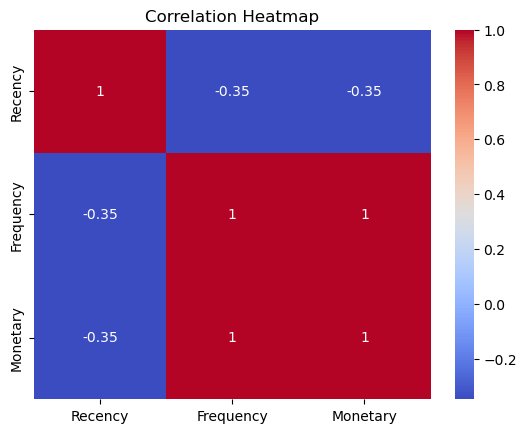

In [126]:
#Correlation between Recency, Frequency and monetary values
sns.heatmap(rfm.iloc[:,0:4].corr() , annot=True, cmap = "coolwarm" )
plt.title('Correlation Heatmap')

#### 5.3.GENDER -RFM Analizi

In [127]:
df.head(2)

customer_id           event                                             value  time_in_days                          offer_id  amount offer_type  offer_difficulty  offer_duration  web  email  mobile  social gender  age became_member_on  customer_income  membership_year customer_income_range age_category  offer completed
0  78afa995795e4d85b5d9ceeca43f5fef  offer received  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}             0  9b98b8c7a33c4b65b9aebfe6a799e6d9  12.777       bogo             5.000               7    1      1       1       0      F   75       2017-05-09           100000             2017                $100K+        Yaşlı                0
1  78afa995795e4d85b5d9ceeca43f5fef    offer viewed  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}             0  9b98b8c7a33c4b65b9aebfe6a799e6d9  12.777       bogo             5.000               7    1      1       1       0      F   75       2017-05-09           100000             2017                $100K+        Yaşlı                0

In [128]:
rfm.head(2)

customer_id  Recency  Frequency  Monetary recency_score monetary_score frequency_score RFM_SCORE    segment
6848  7e45faba0a8346379d0c296f1df8ae1d        0         18   229.992             5              5               5        55  champions
7458  89939d40a29c4cec90827c6a370306a6        0         18   229.992             5              5               5        55  champions

In [129]:
#customer_id bazında birleştir
rfm_val= pd.merge(df, rfm, left_on='customer_id', right_on='customer_id', how='inner')

In [130]:
rfm_val.head(2)

customer_id           event                                             value  time_in_days                          offer_id  amount offer_type  offer_difficulty  offer_duration  web  email  mobile  social gender  age became_member_on  customer_income  membership_year customer_income_range age_category  offer completed  Recency  Frequency  Monetary recency_score monetary_score frequency_score RFM_SCORE    segment
0  78afa995795e4d85b5d9ceeca43f5fef  offer received  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}             0  9b98b8c7a33c4b65b9aebfe6a799e6d9  12.777       bogo             5.000               7    1      1       1       0      F   75       2017-05-09           100000             2017                $100K+        Yaşlı                0        5         11   140.551             5              3               4        54  champions
1  78afa995795e4d85b5d9ceeca43f5fef    offer viewed  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}             0  9b98b8c7a33c4b65b9aebfe6a799e6d9  12.777       bogo             5.000               7    1      1       1       0      F   75       2017-05-09           100000             2017                $100K+        Yaşlı                0        5         11   140.551             5              3               4        54  champions

In [131]:
# Sadece segment ve gender değişkenlerini seçmek istiyorum
selected_columns = ['segment', 'gender']
gender_df = rfm_val[selected_columns]
gender_df.sample(4)

segment gender
73032       champions      M
26775       champions      M
124844  new_customers      M
77143       champions      M

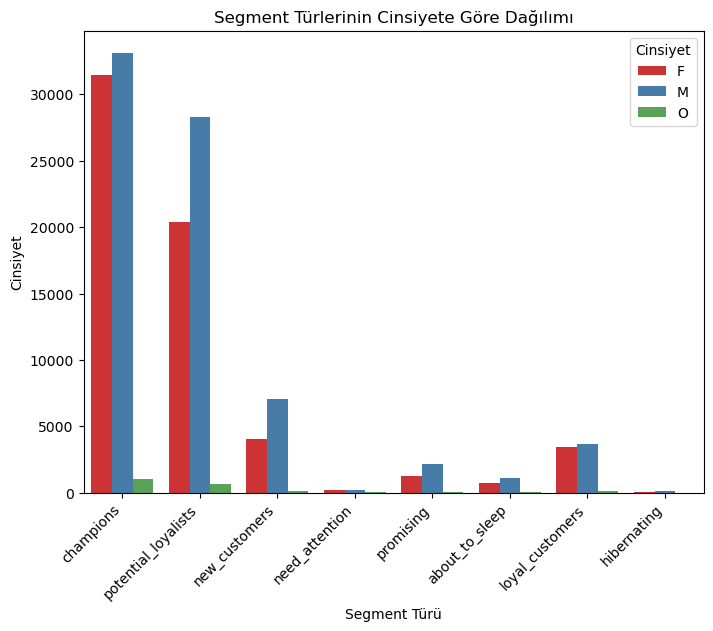

In [132]:
#RFM Segment Türlerinin Cinsiyete Göre Dağılımı'
plt.figure(figsize=(8, 6))
sns.countplot(data=gender_df, x='segment', hue='gender', palette='Set1')
plt.xlabel('Segment Türü')
plt.ylabel('Cinsiyet')
plt.title('Segment Türlerinin Cinsiyete Göre Dağılımı')
plt.legend(title='Cinsiyet', loc='upper right')
plt.xticks(rotation=45, ha='right')
plt.show()

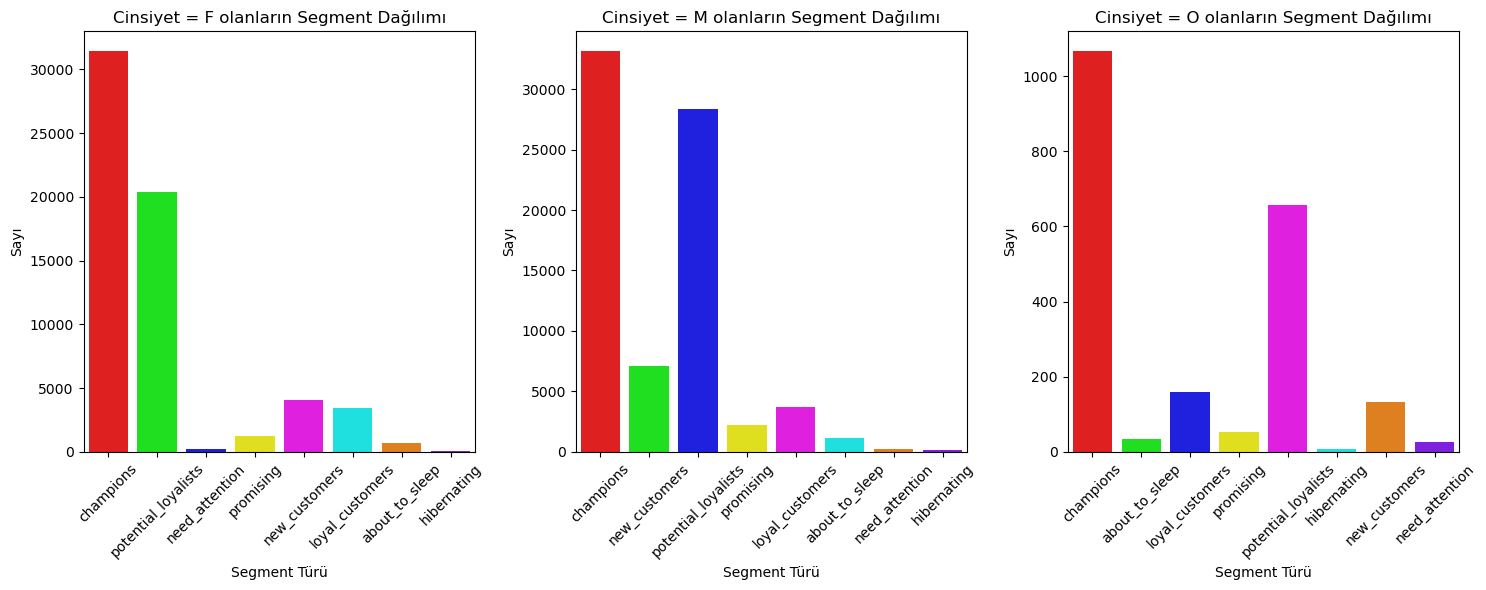

In [133]:
genders = gender_df['gender'].unique()

# Yan yana grafikler oluştur
fig, axes = plt.subplots(1, len(genders), figsize=(15, 6))

for i, gender in enumerate(genders):
    # Cinsiyete göre veriyi grupla
    gender_data = gender_df[gender_df['gender'] == gender]
    
    # Grafik
    sns.countplot(data=gender_data, x='segment', palette=['#ff0000', '#00ff00', '#0000ff', '#ffff00', '#ff00ff', '#00ffff',
              '#ff8000', '#8000ff', '#0080ff', '#ff0080', '#80ff00', '#00ff80'], ax=axes[i])
    axes[i].set_xlabel('Segment Türü')
    axes[i].set_ylabel('Sayı')
    axes[i].set_title(f'Cinsiyet = {gender} olanların Segment Dağılımı')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


#### 5.4. AGE_CAT - RFM Analizi 

In [134]:
rfm_val.sample(2)

customer_id            event                                              value  time_in_days                          offer_id  amount offer_type  offer_difficulty  offer_duration  web  email  mobile  social gender  age became_member_on  customer_income  membership_year customer_income_range   age_category  offer completed  Recency  Frequency  Monetary recency_score monetary_score frequency_score RFM_SCORE              segment
71115  73d69d9ca6614a74aa22018020d33587     offer viewed   {'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}            24  2298d6c36e964ae4a3e7e9706d1fb8c2  12.777   discount             7.000               7    1      1       1       1      M   42       2018-04-05            62000             2018      $(50,000-74,999)  Genç Yetişkin                0        3         10   127.774             5              3               3        53  potential_loyalists
13300  f62c31aa3c65443eac8b18800bfb6a8f  offer completed  {'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...            13  9b98b8c7a33c4b65b9aebfe6a799e6d9  12.777       bogo             5.000               7    1      1       1       0      M   44       2015-06-14            55000             2015      $(50,000-74,999)  Genç Yetişkin                1        5         10   127.774             5              3               3        53  potential_loyalists

In [135]:
# Sadece age_category ve segment değişkenlerini seç
selected_columns = ['segment', 'age_category']
age_df = rfm_val[selected_columns]
age_df.sample(4)

segment   age_category
8344    potential_loyalists  Genç Yetişkin
109498            champions   Son Yetişkin
54302   potential_loyalists          Yaşlı
125312        new_customers  Genç Yetişkin

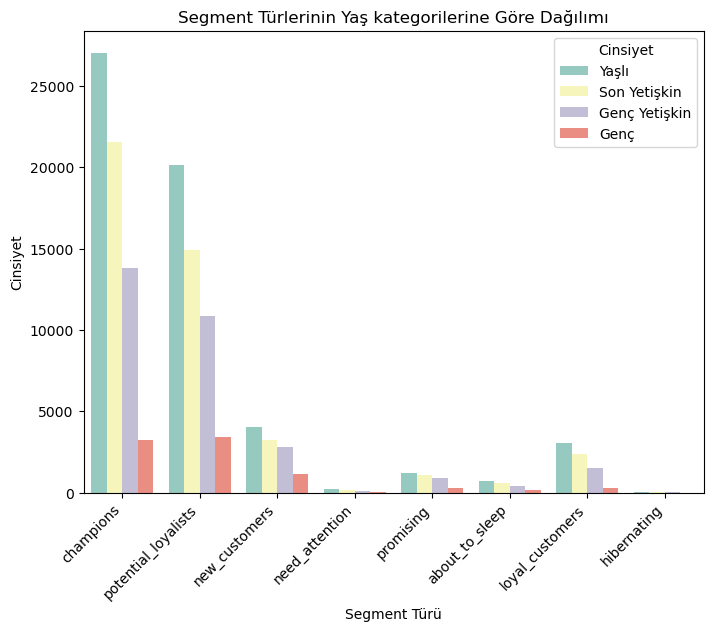

In [136]:
#RFM Segment Türlerinin Yaş kategorilerine Göre Dağılımı'
plt.figure(figsize=(8, 6))
sns.countplot(data=age_df, x='segment', hue='age_category', palette='Set3')
plt.xlabel('Segment Türü')
plt.ylabel('Cinsiyet')
plt.title('Segment Türlerinin Yaş kategorilerine Göre Dağılımı')
plt.legend(title='Cinsiyet', loc='upper right')
plt.xticks(rotation=45, ha='right')
plt.show()

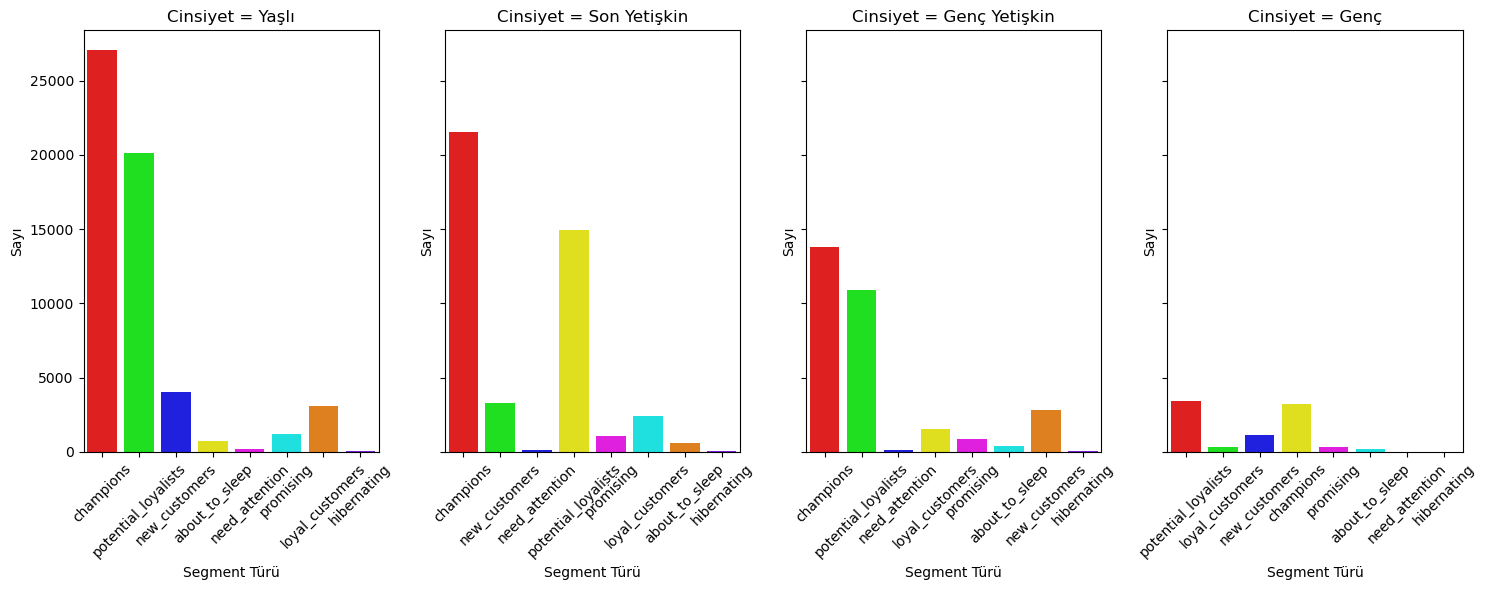

In [137]:
age_cat = age_df['age_category'].unique()

# Yan yana grafikler oluştur
fig, axes = plt.subplots(1, len(age_cat), figsize=(15, 6), sharey=True)

for i, age_category in enumerate(age_cat):
    # Cinsiyete göre veriyi grupla
    age_data = age_df[age_df['age_category'] == age_category]
    
    # Grafik
    sns.countplot(data=age_data, x='segment', palette=['#ff0000', '#00ff00', '#0000ff', '#ffff00', '#ff00ff', '#00ffff',
              '#ff8000', '#8000ff', '#0080ff', '#ff0080', '#80ff00', '#00ff80'], ax=axes[i])
    axes[i].set_xlabel('Segment Türü')
    axes[i].set_ylabel('Sayı')
    axes[i].set_title(f'Cinsiyet = {age_category}')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout(h_pad=2)
plt.show()


#### 5.5 CUSTOMER İNCOME RANGE - RFM Analizi 

In [138]:
rfm_val.sample(2)

customer_id            event                                              value  time_in_days                          offer_id  amount     offer_type  offer_difficulty  offer_duration  web  email  mobile  social gender  age became_member_on  customer_income  membership_year customer_income_range   age_category  offer completed  Recency  Frequency  Monetary recency_score monetary_score frequency_score RFM_SCORE              segment
77943  56e7eed3e35a44dbb222d792cda320b7   offer received   {'offer id': '5a8bc65990b245e5a138643cd4eb9837'}            21  5a8bc65990b245e5a138643cd4eb9837  12.777  informational             0.000               3    0      1       1       1      F   72       2015-12-04            55000             2015      $(50,000-74,999)          Yaşlı                0        5         16   204.438             5              5               5        55            champions
82970  def4837ebbf546ffb3a7966edc8fdba8  offer completed  {'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...            15  fafdcd668e3743c1bb461111dcafc2a4  12.777       discount            10.000              10    1      1       1       1      F   40       2015-01-18            54000             2015      $(50,000-74,999)  Genç Yetişkin                1        0         11   140.551             5              3               3        53  potential_loyalists

In [139]:
# Sadece customer_income_range ve segment değişkenlerini seç
selected_columns = ['segment', 'customer_income_range']
income_df = rfm_val[selected_columns]
income_df.sample(2)

segment customer_income_range
98421  champions      $(50,000-74,999)
48081  champions      $(50,000-74,999)

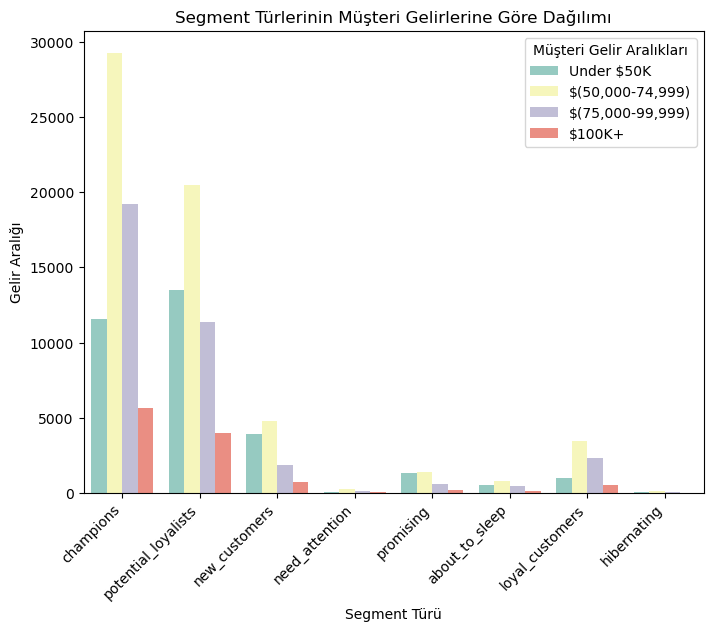

In [140]:
#RFM Segment Türlerinin Müşteri Gelir Aralıklarına Göre Dağılımı'
plt.figure(figsize=(8, 6))
sns.countplot(data=income_df, x='segment', hue='customer_income_range', palette='Set3')
plt.xlabel('Segment Türü')
plt.ylabel('Gelir Aralığı')
plt.title('Segment Türlerinin Müşteri Gelirlerine Göre Dağılımı')
plt.legend(title='Müşteri Gelir Aralıkları', loc='upper right')
plt.xticks(rotation=45, ha='right')
plt.show()

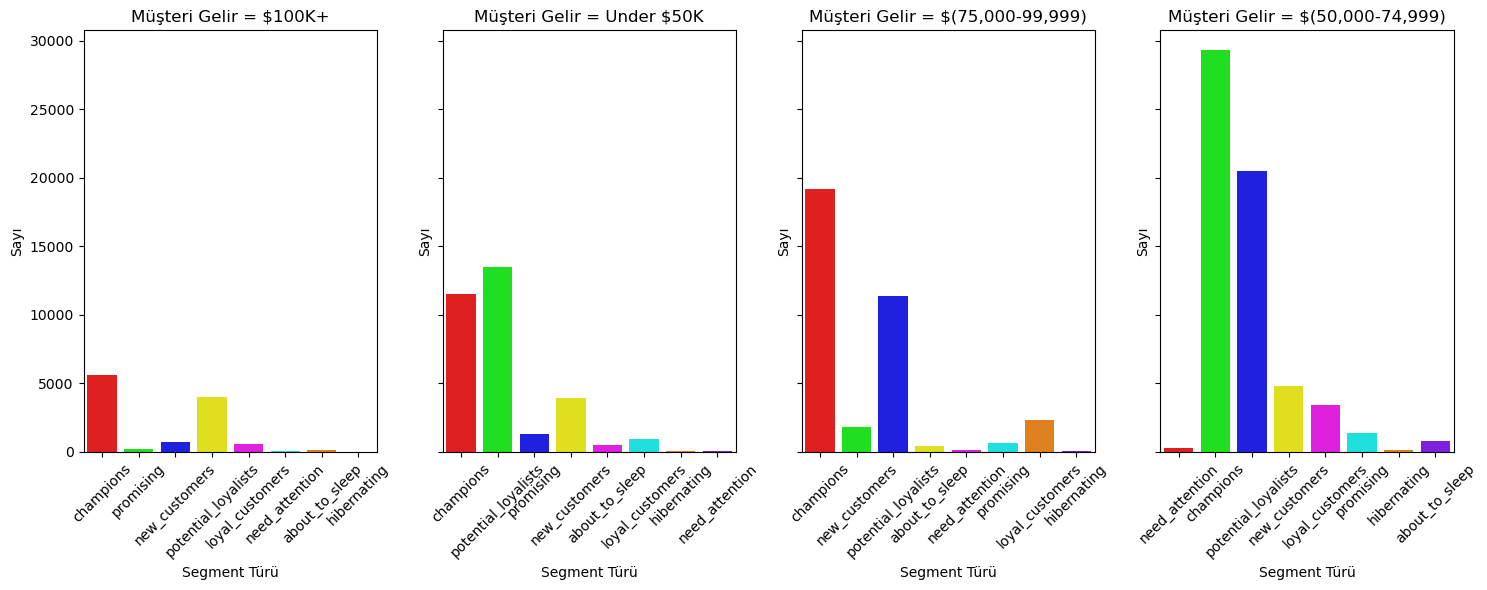

In [141]:
income_range = income_df['customer_income_range'].unique()

# Yan yana grafikler oluştur
fig, axes = plt.subplots(1, len(income_range), figsize=(15, 6), sharey=True)

for i, customer_income_range in enumerate(income_range):
    # Gelir aralığına göre göre veriyi grupla
    income_data = income_df[income_df['customer_income_range'] == customer_income_range]
    
    # Grafik
    sns.countplot(data=income_data, x='segment', palette=['#ff0000', '#00ff00', '#0000ff', '#ffff00', '#ff00ff', '#00ffff',
              '#ff8000', '#8000ff', '#0080ff', '#ff0080', '#80ff00', '#00ff80'], ax=axes[i])
    axes[i].set_xlabel('Segment Türü')
    axes[i].set_ylabel('Sayı')
    axes[i].set_title(f'Müşteri Gelir = {customer_income_range}')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout(h_pad=2)
plt.show()


#### 5.6.  Membershıp Year - RFM Analizi 

In [142]:
rfm_val.sample(2)

customer_id           event                                             value  time_in_days                          offer_id  amount offer_type  offer_difficulty  offer_duration  web  email  mobile  social gender  age became_member_on  customer_income  membership_year customer_income_range age_category  offer completed  Recency  Frequency  Monetary recency_score monetary_score frequency_score RFM_SCORE              segment
49371  5bfbf2afd12c4f49931e100c26506855  offer received  {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}             7  fafdcd668e3743c1bb461111dcafc2a4  12.777   discount            10.000              10    1      1       1       1      M   76       2017-11-30            50000             2017      $(50,000-74,999)        Yaşlı                0        5         11   140.551             5              3               4        54            champions
82916  7dd8f1f777494b70a41fa2f6ac9901a4    offer viewed  {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}             1  4d5c57ea9a6940dd891ad53e9dbe8da0  12.777       bogo            10.000               5    1      1       1       1      M   20       2018-02-20            31000             2018            Under $50K         Genç                0        8          8   102.219             4              2               2        42  potential_loyalists

In [143]:
# Sadece membership_year  ve segment değişkenlerini seç
selected_columns = ['segment', 'membership_year']
year_df = rfm_val[selected_columns]
year_df.sample(2)

segment  membership_year
52718  potential_loyalists             2017
8010         new_customers             2017

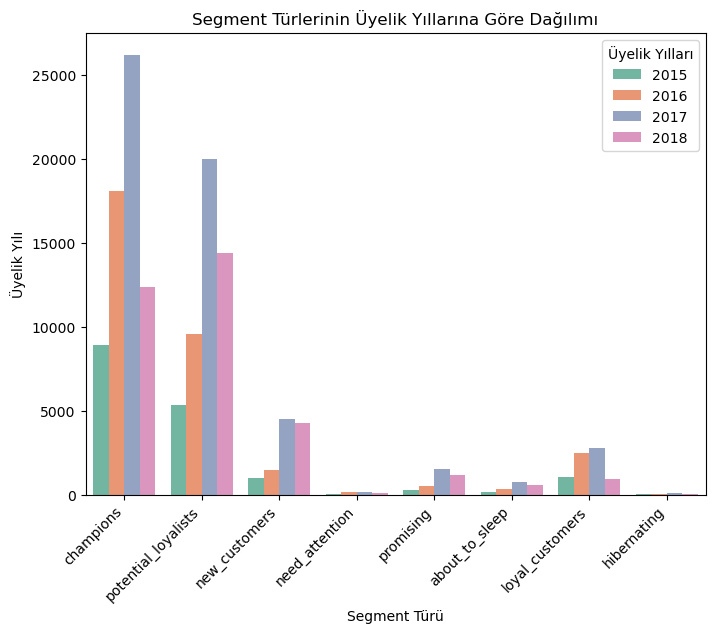

In [144]:
# RFM Segment Türlerinin Üyelik Yıllarına Göre Dağılımı
plt.figure(figsize=(8, 6))
sns.countplot(data=year_df, x='segment', hue='membership_year', palette='Set2')
plt.xlabel('Segment Türü')
plt.ylabel('Üyelik Yılı')
plt.title('Segment Türlerinin Üyelik Yıllarına Göre Dağılımı')
plt.legend(title='Üyelik Yılları', loc='upper right')
plt.xticks(rotation=45, ha='right')
plt.show()


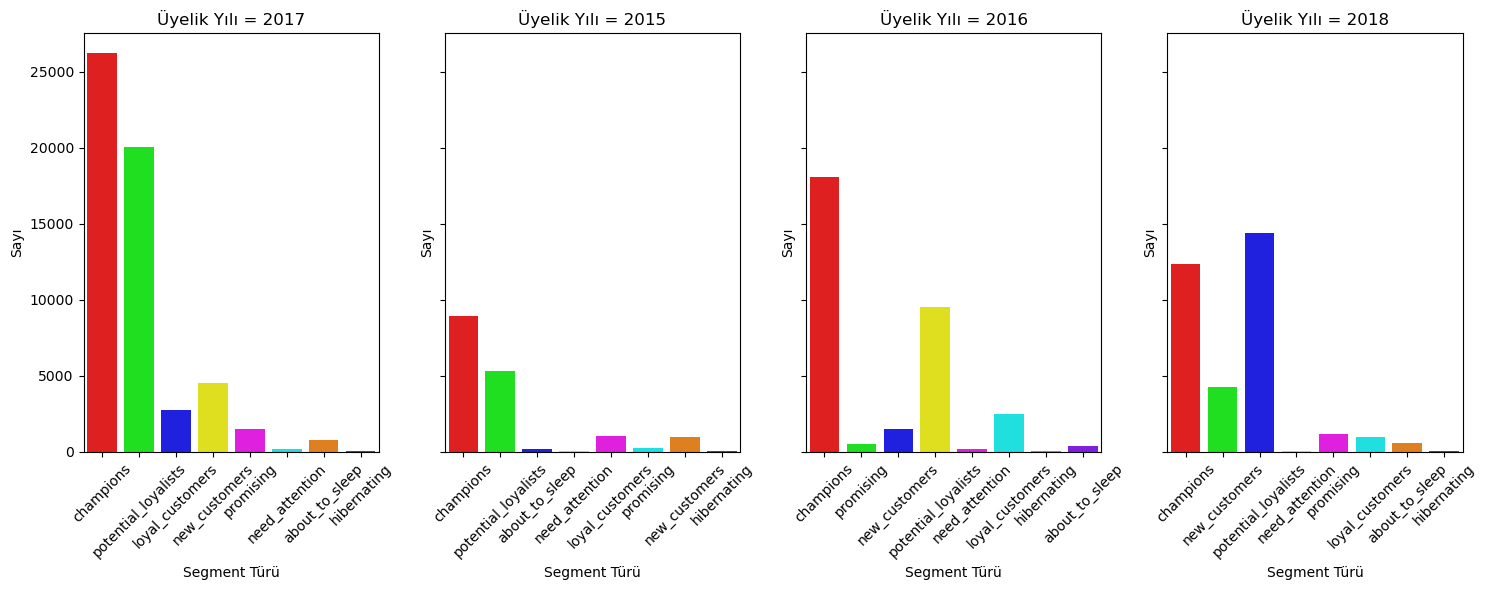

In [145]:
income_range = year_df['membership_year'].unique()

# Yan yana grafikler oluştur
fig, axes = plt.subplots(1, len(income_range), figsize=(15, 6), sharey=True)

for i, membership_year in enumerate(income_range):
    # Üyelik yılına göre veriyi grupla
    year_data = year_df[year_df['membership_year'] == membership_year]
    
    # Grafik
    sns.countplot(data=year_data, x='segment', palette=['#ff0000', '#00ff00', '#0000ff', '#ffff00', '#ff00ff', '#00ffff',
              '#ff8000', '#8000ff', '#0080ff', '#ff0080', '#80ff00', '#00ff80'], ax=axes[i])
    axes[i].set_xlabel('Segment Türü')
    axes[i].set_ylabel('Sayı')
    axes[i].set_title(f'Üyelik Yılı = {membership_year}')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout(h_pad=2)
plt.show()


#### 5.7. OFFER_TYPE - RFM Analizi  

In [146]:
rfm_val.sample(1)

customer_id           event                                             value  time_in_days                          offer_id  amount offer_type  offer_difficulty  offer_duration  web  email  mobile  social gender  age became_member_on  customer_income  membership_year customer_income_range age_category  offer completed  Recency  Frequency  Monetary recency_score monetary_score frequency_score RFM_SCORE    segment
91265  38f02eb17af04d55b4cff9dacba7e54c  offer received  {'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}             0  f19421c1d4aa40978ebb69ca19b0e20d  12.777       bogo             5.000               5    1      1       1       1      M   65       2015-12-17            80000             2015      $(75,000-99,999)        Yaşlı                0        5         14   178.883             5              5               5        55  champions

In [147]:
# Sadece offer_type ve segment değişkenlerini seç
selected_columns = ['segment', 'offer_type']
offert_df = rfm_val[selected_columns]
offert_df.sample(2)

segment offer_type
35000  loyal_customers       bogo
5889         champions       bogo

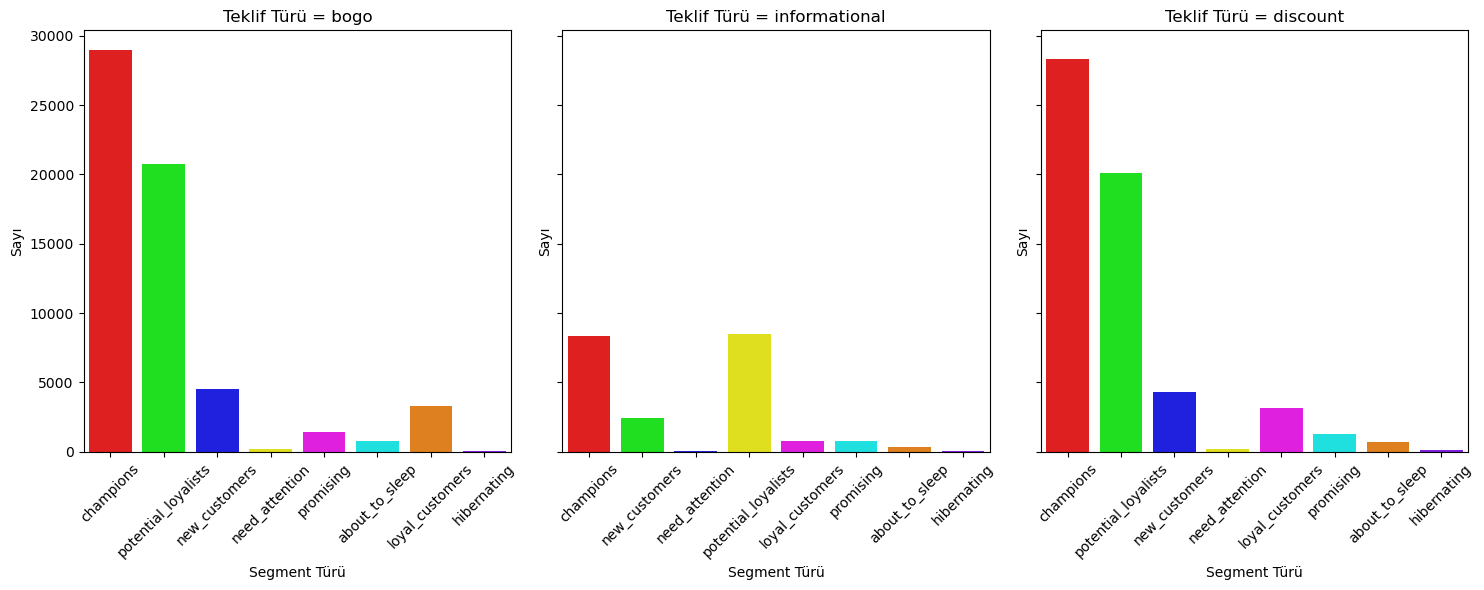

In [148]:
offer_types = offert_df['offer_type'].unique()

# Yan yana grafikler oluştur
fig, axes = plt.subplots(1, len(offer_types), figsize=(15, 6), sharey=True)

for i, offer_type in enumerate(offer_types):
    # Teklif türüne göre veriyi grupla
    offer_data = offert_df[offert_df['offer_type'] == offer_type]
    
    # Grafik
    sns.countplot(data=offer_data, x='segment', palette=['#ff0000', '#00ff00', '#0000ff', '#ffff00', '#ff00ff', '#00ffff',
              '#ff8000', '#8000ff', '#0080ff', '#ff0080', '#80ff00', '#00ff80'], ax=axes[i])
    axes[i].set_xlabel('Segment Türü')
    axes[i].set_ylabel('Sayı')
    axes[i].set_title(f'Teklif Türü = {offer_type}')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout(h_pad=2)
plt.show()
